<div class="alert-warning">
 <font size="+2"> <b> Single Cell Analysis Tutorial </b> </font>
</div>


This tutorial will give you the basic commands for the single cell analysis of your own dataset. 

The **first part of the tutorial** is focused on filtering a dataset (that you will find in this same folder).

The **second part of the tutorial** is focused on integrating all sixteen datasets produced from the lab sessions (you will perform this integration analysis in groups). Here we will identify cell types and find a population of cells expressing the HAR1 gene to analyze different conditions of mutant VS wild type Lotus japonicus.

The tutorial is based on four samples of Lotus Japonicus (two controls and two wild types) from [the paper discussed during week 6](https://www.biorxiv.org/content/10.1101/2022.12.23.521739v1).

At the end of this tutorial **you will be able to use `R` to**

- Filter your data selecting specific criteria
- Preprocess your data for advanced analysis
- Merge datasets and do cross-data analysis
- Identify potential cell types 
- Perform differential gene expression
- Visualize the gene networks in your data

# UMI-based single cell data from microdroplets



The dataset is based on a **microdroplet-based method from 10X chromium**. We remember that a microdroplet single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet

<figure>
<img src="images/droplet.gif" width="700" alt="Annotated Data">
<figcaption> Figure:  Isolation of cells and beads into microdroplets.</figcaption>
    </figure>

- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
<figure>
<img src="images/10X.png" width="700" alt="Annotated Data">
<figcaption> Figure:  steps for the microdroplet-based single cell RNA sequencing after isolation.</figcaption>
    </figure>

## The raw data in practice

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGACCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCNTGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--<JFFF-7--7<<-F77---FF---7-7A-777777A-<-7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing happens from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

## Alignment and expression matrix

The data is aligned with `cellranger`, a completely automatized [pipeline implemented by 10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) for 10X-genomics data.

Apart from the data, the output contains an interactive document reporting the quality of the data and a small preliminary UMAP plot and clustering. In this report it is especially instructive to look at the **knee plot**. 

The knee plot is created by plotting the number of unique molecular identifiers (UMIs) or reads against the number of cells sequenced, sorted in descending order. The UMIs or reads are a measure of the amount of RNA captured for each cell, and thus a measure of the quality of the data. The plot typically shows a **steep slope at the beginning, followed by a plateau, and then a gradual decrese into a second slope and a final plateau**. 

* The steep slope represents the initial cells that are of **high quality** and have the highest number of UMIs or reads. 
* The first plateau represents the cells that have **lower quality data**, and the gradual decrease represents the addition of droplets with even lower quality data. 
* Usually, beyond the first slope, you have droplets that are **either empty or of so poor quality**, that they are not worth keeping for analysis.
* The height of the last plateau gives you an idea of the **presence of ambient RNA** inside droplets. If the last plateau is located high up, then the corresponding amount of UMIs consist of background ambient RNA which likely pollutes all cells in your data.

Below, the knee plot from the `control 1` sample used in this analysis. You can see that around 10,000 cells with above ~1000 UMIs seems to be coinsidered of decent quality by `cellranger` (the part of line coloured in blue). Note that the last plateau is located at a very low amount of UMIs, meaning there is not really any relevant contamination from ambient RNA.

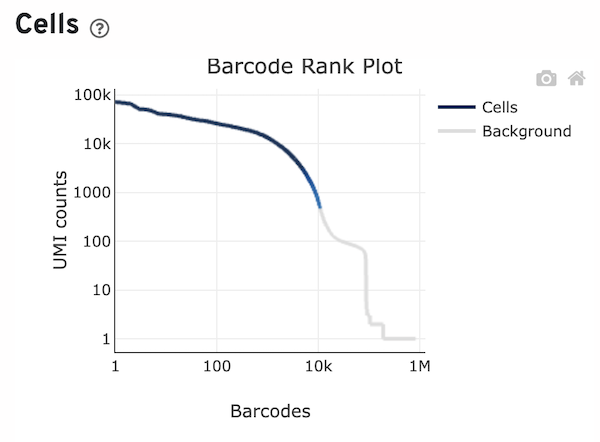

In this same folder you havethe document `web_summary.html` that shows you the quality report of your own dataset. **Take some time to look at it and explore what it contains** (Click on `Trust HTML` on the top menu if the html remains blank after opening it). Get an idea of how many UMIs there are in cells of decent quality. We will work more on filtering out cells based on their quality in this tutorial.

# Preprocessing

We will answer to the following questions:

* How can I **import single-cell data** into R?
* How are different types of data/information (e.g. cell information, gene information, etc.) **stored and manipulated**?
* How can I obtain basic **summary metrics** for cells and genes and **filter the data** accordingly?
* How can I **visually explore** these metrics?

We start by loading all the packages necessary for the analysis

In [1]:
suppressPackageStartupMessages({ library(SeuratDisk); 
library(Seurat);
library(DoubletFinder);
library(parallel);
library(multtest);
library(metap);
library(purrr);
library(dplyr);
library(stringr);
library(tibble);
library(ggplot2);
library(MAST);})

In [2]:
options(future.seed=TRUE)

In [3]:
plan("multicore", workers = 8)
options(future.globals.maxSize = 8 * 1024^3)

## Import data

We import the data reading the matrix files aligned by 10X. Those are usually contained in a folder of the type `aligned_dataset/outs/filtered_bc_matrix` that 10X Cellranger creates automatically after the alignment - you will use such a folder when your own data is aligned. In our case, the files for this tutorial exercise are in the folder used below. The command for reading the data is simply `Read10X`. **When you analyze your own data, you have to use the correct folder name below (for example `Aligned_Gifu_ctr_1/outs/filtered_bc_matrix`)**

In [ ]:
WT_Control1_10dpi <- Read10X("../tutorial_data/control_1/")

Note that we are loading only one dataset (`control_1`, one of the two control replicates). Another control dataset, and two wild type datasets, have already been preprocessed and will be used later - so we will now focus on the preprocessing of a single dataset.

What we obtain is a matrix created from some storage-saving matrix files which are quite obscure to read. Look at the first 10 rows and columns of the matrix (whose rows represent genes and columns droplets/cells) - the dots are zeros (they are not stored in the data, which has a compressed format called `dgCMatrix`), and are the majority of the expression values obtained in scRNA data!

In [24]:
WT_Control1_10dpi[1:10,1:10]

  [[ suppressing 10 column names ‘AAACCCAAGGGCAGTT-1’, ‘AAACCCAAGTCAGCGA-1’, ‘AAACCCACACTAACCA-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                         
LotjaGi0g1v0000100    . . . . . . . . . .
LotjaGi0g1v0000200    . . . . . . . . . .
LotjaGi0g1v0000300    . . . . . . . . . .
LotjaGi0g1v0000400    . . . . . . 1 1 . .
LotjaGi0g1v0000500    . . . . . . . . . .
LotjaGi0g1v0000600    . . . . . . . . . .
LotjaGi0g1v0000700    . . . . . . . . . .
LotjaGi0g1v0000800    . . . . 1 . . . . .
LotjaGi0g1v0000900_LC . . . . . . . . . .
LotjaGi0g1v0001000_LC . . . . . . . . . .

What is the percentage of zeros in this matrix? You can see it for yourself below - it is a lot, but quite surprisingly we can get a lot of information from the data!

In [25]:
cat("Number of zeros: ")
zeros <-  sum(WT_Control1_10dpi==0)
cat( zeros )

Number of zeros: 307060673

In [26]:
cat("Number of expression entries: ")
total <- dim(WT_Control1_10dpi)[1] * dim(WT_Control1_10dpi)[2]
cat( total )

Number of expression entries: 329798055

In [27]:
cat("Percentage of zeros: ")
cat( zeros / total * 100 )

Percentage of zeros: 93.10567

## Create a single cell object in Seurat

We use our count matrix to create a Seurat object. A Seurat object allows you to **store the count matrix** and future modifications of it (for example its normalized version), together with **information regarding cells and genes** (such as clusters of cell types) and their **projections** (such as PCA and tSNE). We will go through these elements, but first we create the object with `CreateSeuratObject`:

In [28]:
WT_Control1_10dpi_seurat <- CreateSeuratObject(counts = WT_Control1_10dpi, 
                                               project = "WT_Control1_10dpi_seurat", 
                                               min.cells = 3, 
                                               min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


The arguments of the command are 
* `counts`: the count matrix
* `project`: a project name
* `min.cells`: a minimum requirement for genes, in our case saying they must be expressed in at least 3 cells. If not, they are filtered out already now when creating the object.
* `min.features`: a minimum requirement for cells. Cells having less than 200 expressed genes are removed from the beginning from the data.

Values for the minimum requirements are chosen from usual values when running the analysis. Droplets not satisfying those requirements are of extremely bad quality and not worth carrying on during the analysis (remember the knee plot). How many genes and cells have been filtered out?

In [29]:
cat("Starting Genes and Cells:\n")
cat( dim(WT_Control1_10dpi) )

cat("\nFiltered Genes and Cells:\n")
cat( dim(WT_Control1_10dpi) - dim(WT_Control1_10dpi_seurat) )

cat("\nRemaining Genes and Cells:\n")
cat( dim(WT_Control1_10dpi_seurat) )

Starting Genes and Cells:
30585 10783
Filtered Genes and Cells:
6747 11
Remaining Genes and Cells:
23838 10772

We want to use this data later in the analysis with other `Control` and `Wild Type` datasets. Therefore we add already now a metadata value for each cell in our Seurat object. Here we simply add a `Condition` to the metadata table, and for this dataset we establish that each cell is `Control`.

In [30]:
WT_Control1_10dpi_seurat <- AddMetaData(object = WT_Control1_10dpi_seurat, 
                                        metadata = "Control", 
                                        col.name = "Condition")

### Content of a Seurat Object
What is contained in the Seurat object? We can use the command `str` to list the various *slots* of the object.

In [31]:
str(WT_Control1_10dpi_seurat, max.level = 2)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  ..@ meta.data   :'data.frame':	10772 obs. of  4 variables:
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 1 level "WT_Control1_10dpi_seurat": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:10772] "AAACCCAAGGGCAGTT-1" "AAACCCAAGTCAGCGA-1" "AAACCCACACTAACCA-1" "AAACCCACATGATCTG-1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ images      : list()
  ..@ project.name: chr "WT_Control1_10dpi_seurat"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  ..@ commands    : list()
  ..@ tools       : list()


The first slot is called `assays`, and it contains all the count matrices we have collected during our analysis when, for example, normalizing data or doing other transformations of it. Right now we only have the `RNA` assay with the raw counts:

In [32]:
WT_Control1_10dpi_seurat@assays

$RNA
Assay data with 23838 features for 10772 cells
First 10 features:
 LotjaGi0g1v0000100, LotjaGi0g1v0000200, LotjaGi0g1v0000300,
LotjaGi0g1v0000400, LotjaGi0g1v0000500, LotjaGi0g1v0000700,
LotjaGi0g1v0000800, LotjaGi0g1v0001100, LotjaGi0g1v0001200,
LotjaGi0g1v0001400 


You can always select which matrix is currently in use for the analysis by assigning it to `DefaultAssay()`. The default assay is often changed automatically by Seurat, for example the normalized assay is used as default after normalization is performed.

In [33]:
DefaultAssay(object = WT_Control1_10dpi_seurat) <- "RNA"

In [34]:
cat("Your default assay is ")
cat(DefaultAssay(object = WT_Control1_10dpi_seurat))

Your default assay is RNA

The second slot is the one that contains the metadata for each cell. It is easily visualized as a table (the command `head` shows only the first 6 rows of the table):

In [35]:
head( WT_Control1_10dpi_seurat@meta.data )

orig.ident               nCount_RNA nFeature_RNA Condition
AAACCCAAGGGCAGTT-1 WT_Control1_10dpi_seurat  3567      1919         Control  
AAACCCAAGTCAGCGA-1 WT_Control1_10dpi_seurat  7015      2751         Control  
AAACCCACACTAACCA-1 WT_Control1_10dpi_seurat  1484       828         Control  
AAACCCACATGATCTG-1 WT_Control1_10dpi_seurat 20942      4711         Control  
AAACCCAGTAGCTTGT-1 WT_Control1_10dpi_seurat 29105      5157         Control  
AAACCCAGTCTCTCAC-1 WT_Control1_10dpi_seurat  6115      2124         Control

The table contains a name for the dataset (`orig.ident`, useful to distinguish multiple datasets merged together), how many RNA transcripts are contained in each cell (`nCount_RNA`), the number of expressed genes in each cell (`nFeature_RNA`), and the `Condition` (added by us previously). More metadata can be added along the analysis, and some is added automatically by Seurat when running specific commands.

The `assays` and `meta.data` slots are the most relevant and useful to know - the other ones are mostly for internal use by Seurat and we do not go into detail with those.

## Finding filtering criteria

We want to look in depth at which droplets do not contain good quality data, so that we can filter them out. The standard approach - which works quite well - is to study the **distribution of various quality measures and remove doublets** (droplets containing more than one cell) which can confound the analysis results.

### Quality measure distributions

A first step is to calculate the percentage of mitochondrial and chloroplastic genes. A high percentage indicates the presence of spilled material from broken cells. We use the command `PercentageFeatureSet` and provide the pattern of the gene ID which corresponds to mitochondrial and ribosomal genes. The percentages are saved into the metadata simply by using the double squared brackets `[[`.

In [36]:
WT_Control1_10dpi_seurat[["percent.mt"]] <- PercentageFeatureSet(WT_Control1_10dpi_seurat, 
                                                                 pattern = "LotjaGiM1v")
WT_Control1_10dpi_seurat[["percent.chloroplast"]] <- PercentageFeatureSet(WT_Control1_10dpi_seurat, 
                                                                          pattern = "LotjaGiC1v")

You can see the new metadata is now added for each cell

In [37]:
head( WT_Control1_10dpi_seurat@meta.data )

orig.ident               nCount_RNA nFeature_RNA Condition
AAACCCAAGGGCAGTT-1 WT_Control1_10dpi_seurat  3567      1919         Control  
AAACCCAAGTCAGCGA-1 WT_Control1_10dpi_seurat  7015      2751         Control  
AAACCCACACTAACCA-1 WT_Control1_10dpi_seurat  1484       828         Control  
AAACCCACATGATCTG-1 WT_Control1_10dpi_seurat 20942      4711         Control  
AAACCCAGTAGCTTGT-1 WT_Control1_10dpi_seurat 29105      5157         Control  
AAACCCAGTCTCTCAC-1 WT_Control1_10dpi_seurat  6115      2124         Control  
                   percent.mt percent.chloroplast
AAACCCAAGGGCAGTT-1 4.6818054  0.02803476         
AAACCCAAGTCAGCGA-1 0.7127584  0.04276550         
AAACCCACACTAACCA-1 6.6037736  0.06738544         
AAACCCACATGATCTG-1 0.4775093  0.12415242         
AAACCCAGTAGCTTGT-1 0.2954819  0.05497337         
AAACCCAGTCTCTCAC-1 1.6026165  0.01635323

#### Number of transcripts per cell
Below, we plot a histogram of the number of transcripts per cell. On the right side plot, we zoom into the histogram. We want to **filter out the cells with the lowest number of transcripts** - often there is a peak we can identify with a group of low-quality cells. Here we can choose to remove cells with less than ~700 transcripts (some people prefere to do a lighter filtering, and would for example set a threshold to a lower value). We remove also **cells with too many transcripts** that might contain some weird transcripts - which is also helpful for normalization due to some mathematical technicalities. For those we can set a limit to 30000, where there is a very thin tail in the histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7668 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


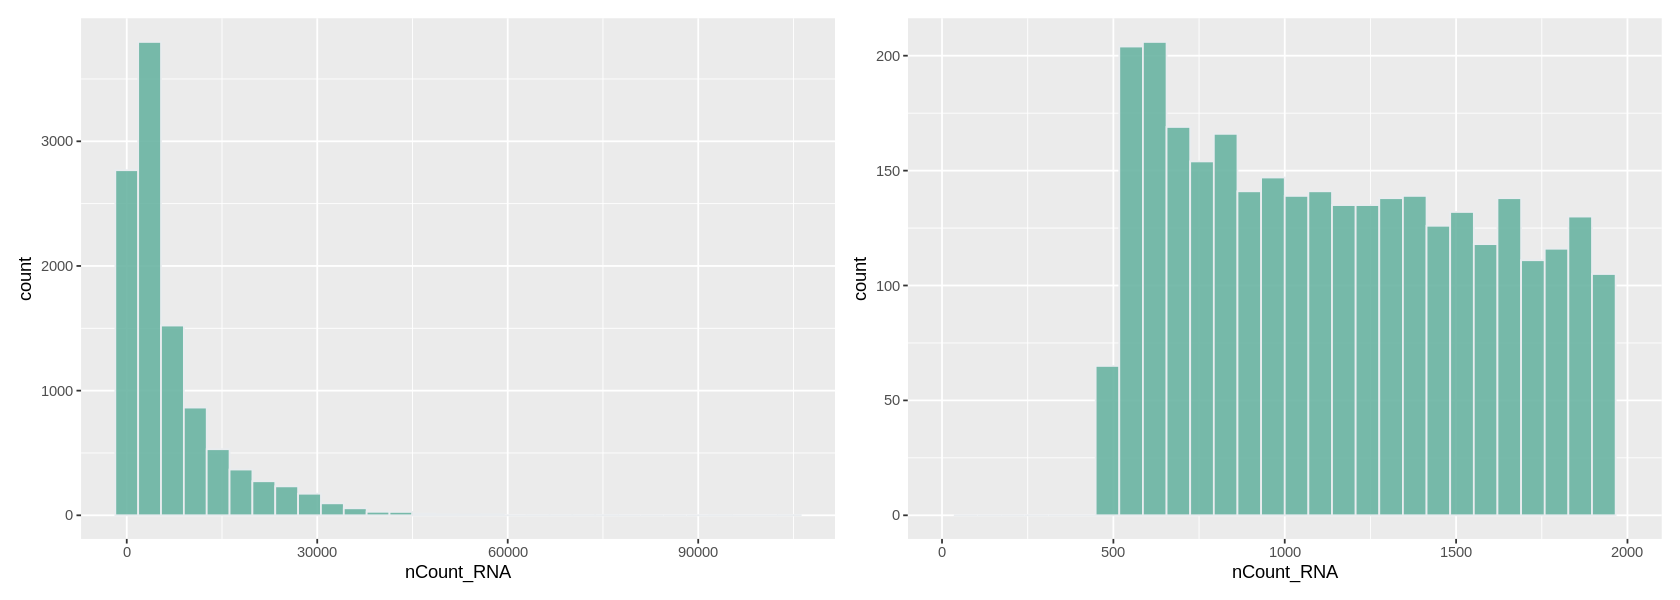

In [38]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,2000)

plot1 + plot2

#### Number of detected genes per cell
Here we work similarly to filter out cells based on how many genes are detected. The right-side plot is a zoom into the histogram. It seems easy to set the thresholds at ~400 and ~7000 detected genes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7793 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


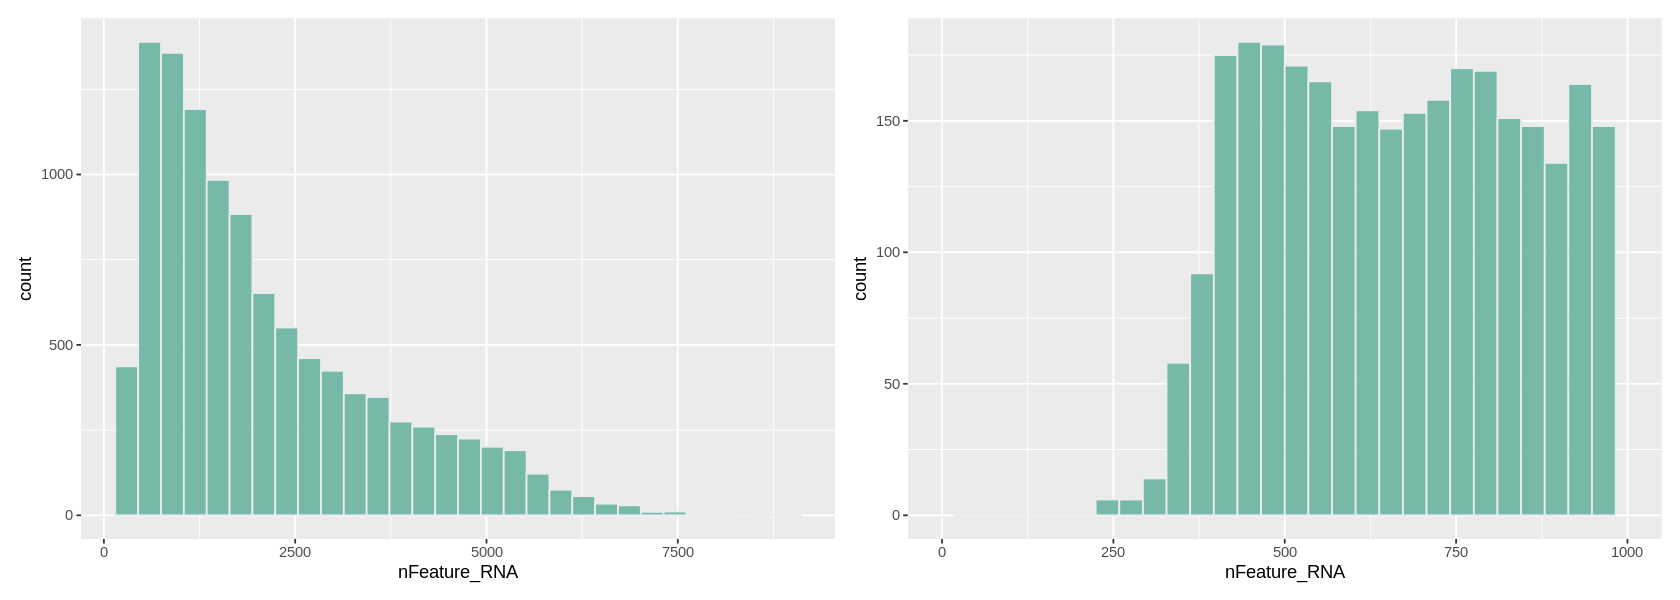

In [39]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,1000)


plot1 + plot2

#### Mitochondrial and Chloroplast percentages

The percentage of mitochondrial and Chloroplasts tells us the data is of good quality. Thresholds are usually set between 5% and 20% in single cell data analysis. In the paper, thresholds were for example set at 20%.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


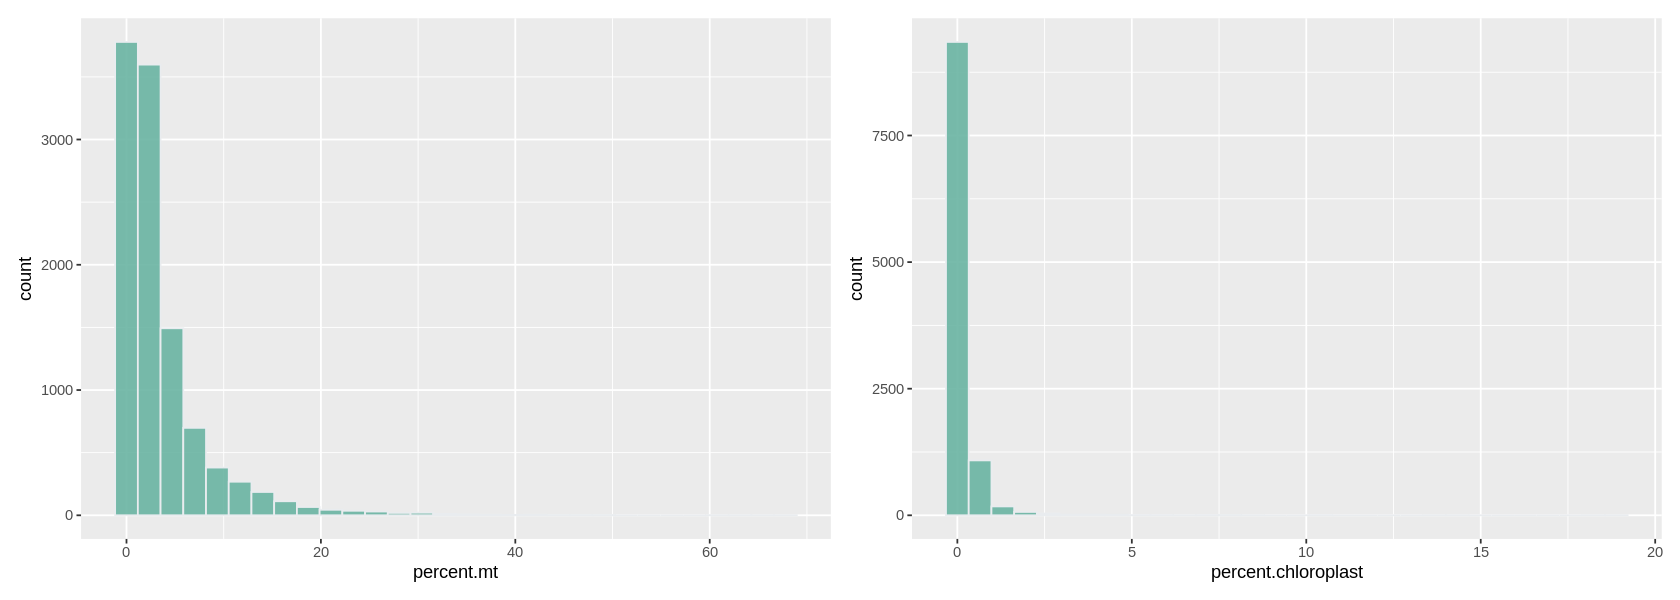

In [40]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=percent.mt)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=percent.chloroplast)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot1 + plot2

#### Counts-Features relationship

Below, we look at the plot of the number of transcripts per cell vs the number of detected genes per cell. Usually, those two measure grow simultaneously. At lower counts the relationship is quite linear, then becomes a curve, typically bending in favour of the number of transcripts per cell. You can see below that each dot (representing a droplet) is coloured by percentage of mitochondria. Droplets with a high percentage of mitochondrial genes also have very low amount of transcripts and detected genes, **confirming that high mitochondrial content is a measure of low quality**.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


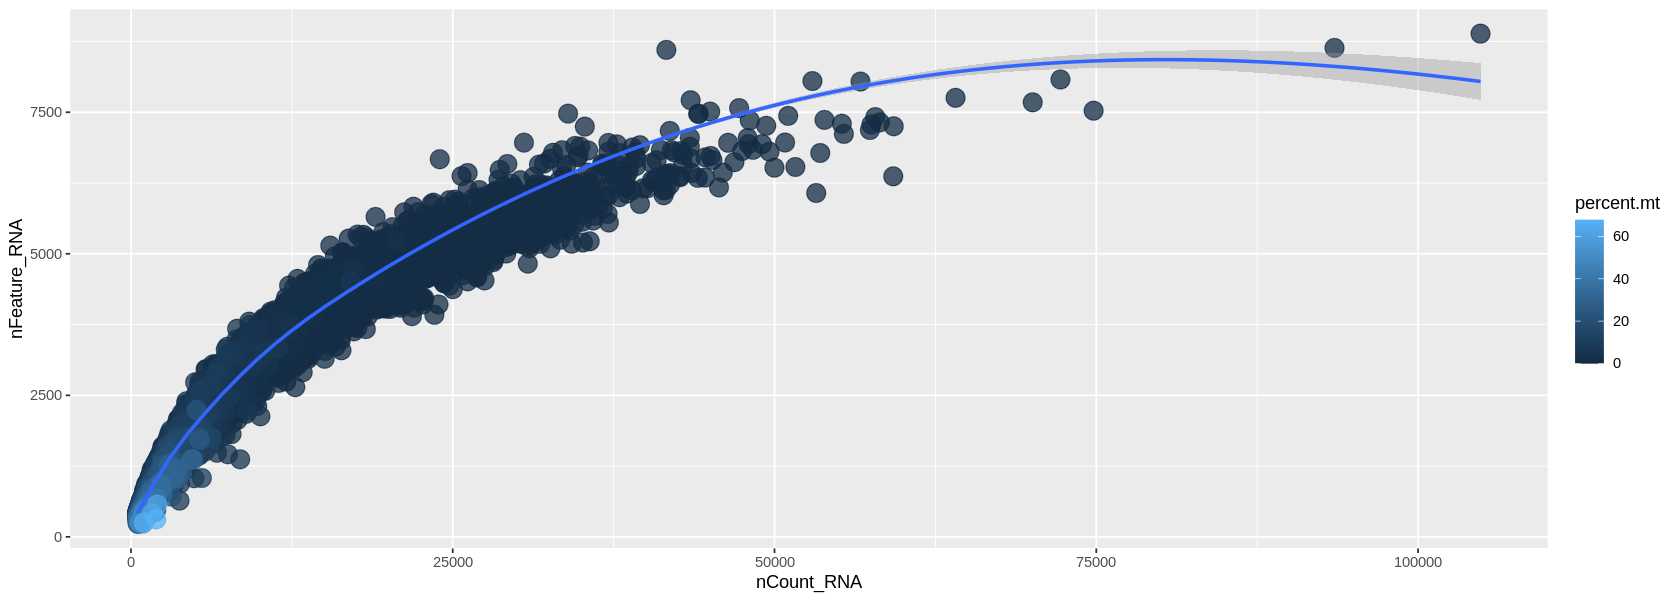

In [41]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

In a similar way the chloroplastic genes confirm the pattern of low quality droplets.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


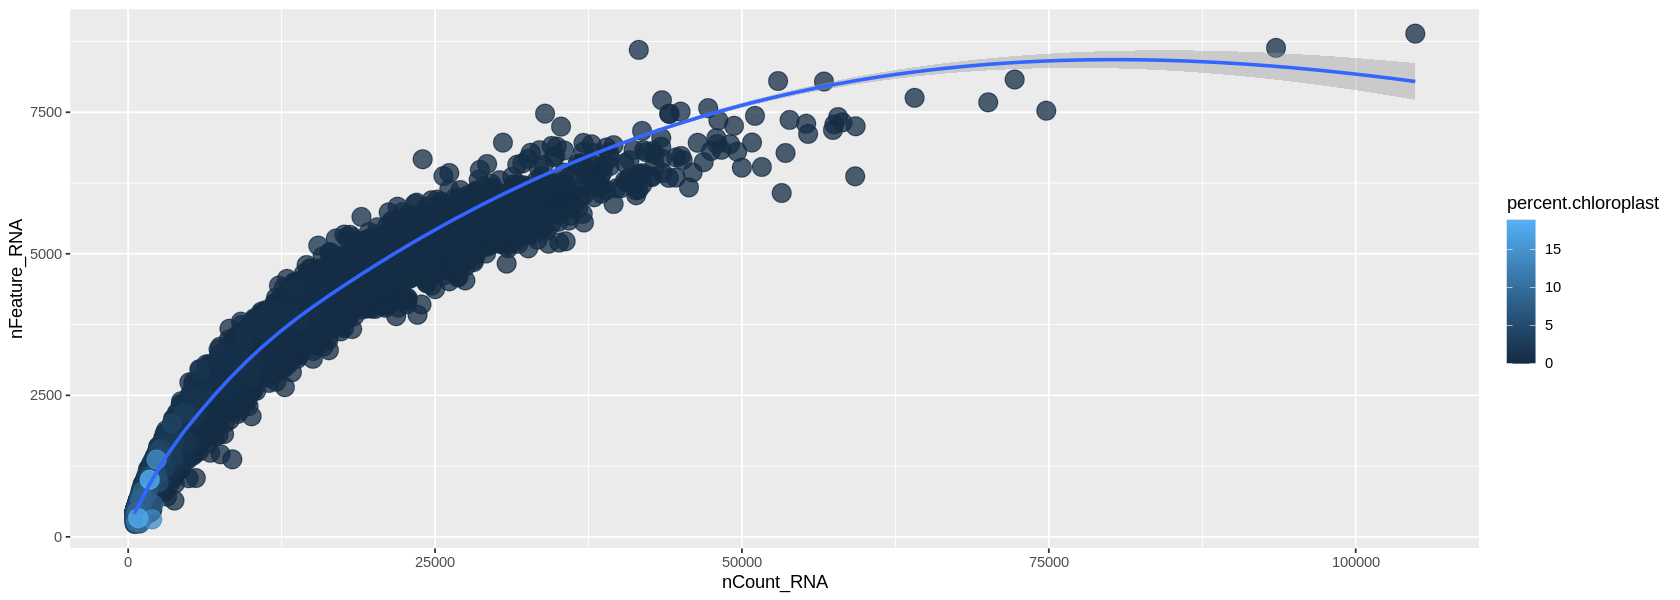

In [42]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat@meta.data %>% arrange(percent.chloroplast)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.chloroplast)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

### Filtering with the chosen criteria

Here we use the command `subset` and impose the criteria we chose above looking at the histograms. We set each criteria for keeping cells of good quality using the names of the features in metadata. We print those names to remember them.

In [43]:
cat("Meta data names:\n")
cat( names(WT_Control1_10dpi_seurat@meta.data), sep='; ' )

Meta data names:
orig.ident; nCount_RNA; nFeature_RNA; Condition; percent.mt; percent.chloroplast

The filtered object is called `WT_Control1_10dpi_seurat_filt`

In [44]:
WT_Control1_10dpi_seurat_filt <- subset(x = WT_Control1_10dpi_seurat, 
                                        subset = nCount_RNA > 700 &
                                                 nCount_RNA < 35000 &
                                                 nFeature_RNA > 400 & 
                                                 nFeature_RNA < 7000 & 
                                                 percent.mt < 5 & 
                                                 percent.chloroplast < 5)

cat("Filtered Genes and Cells: ")
cat( dim(WT_Control1_10dpi_seurat) - dim(WT_Control1_10dpi_seurat_filt) )
cat("\nRemaining Genes and Cells: ")
cat( dim(WT_Control1_10dpi_seurat_filt) )

Filtered Genes and Cells: 0 2762
Remaining Genes and Cells: 23838 8010

Now the transcripts vs genes plot looks as below.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


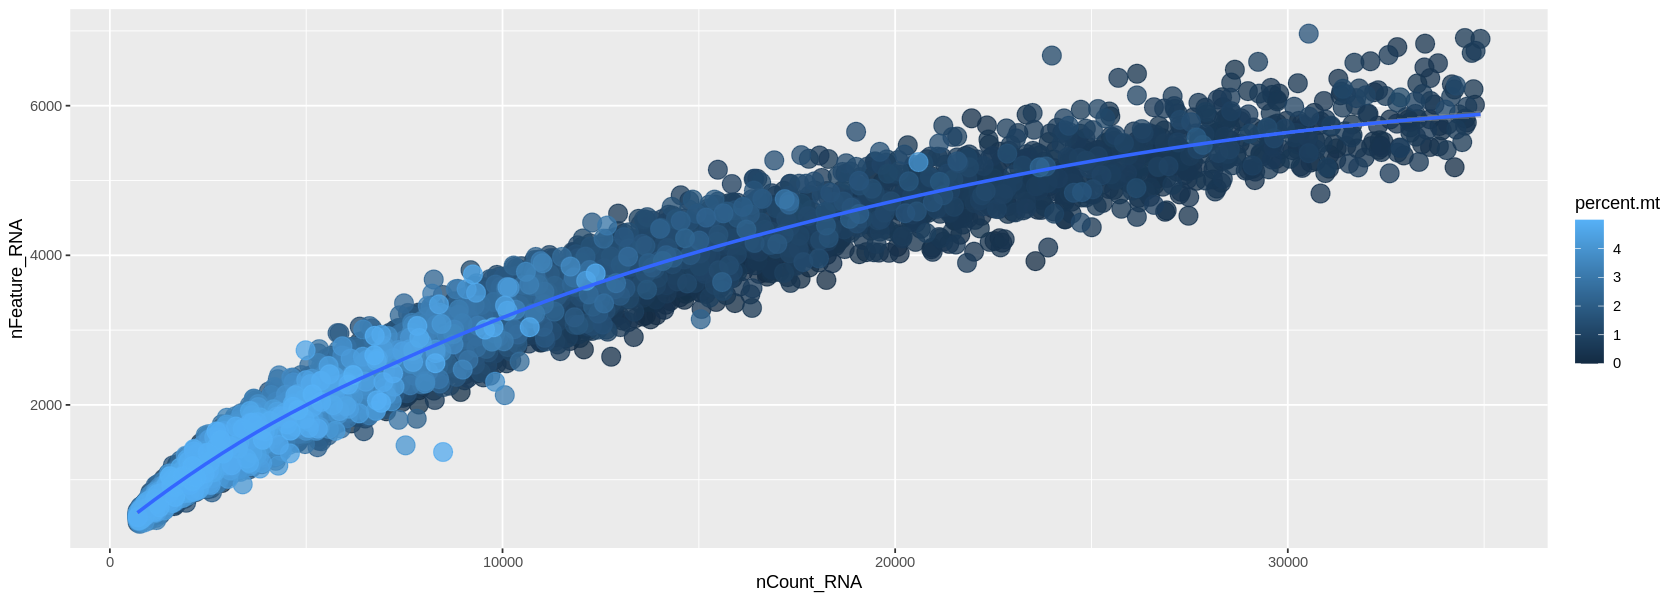

In [45]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat_filt@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

## Normalization

scRNA-seq data is **affected by highly variable RNA quantities and qualities** across different cells. Furthermore, it is often subject to **batch effects, sequencing depth differences, and other technical biases** that can confound downstream analyses.

Normalization methods are used to **adjust for these technical variations so that true biological differences between cells can be accurately identified**.

Some commonly used normalization methods in scRNA-seq data include the following:

* **Total count normalization**: Normalizing the read counts to the total number of transcripts in each sample
* **TPM (transcripts per million)** normalization: Normalizing the read counts to the total number of transcripts in each sample, scaled to a million
* **Library size normalization:** Normalizing the read counts to the total number of reads or transcripts in each sample, adjusted for sequencing depth

A new and more advanced method, at the moment the state-of-the-art, is [`SCTransform`](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1), a software package that can **correct for technical sources of variation and remove batch effects**.

### Finding technical sources of variation

Before normalizing we want to find technical sources of variation in the data. One of those is the total number of transcripts: the influence of this is always removed by `SCtransform`. But we want to look into other possible sources of variation. Those are usually quantities we calculate for each cell, for example the percentage of mitochondrial and chloroplastic genes. 

To see if those quantities actuallhy influence our data a lot, we check how much is their highest correlation with the first 10 components of the PCA of the dataset. In short, **we see if any technical variation is such that it explains much of the data, covering any biological signal**.

Below, we define a function to look at those correlations and plotting them. Do not read the code, it is quite extensive, just run it.

In [46]:
plotCorrelations <- function(object, measures=c('nCount_RNA'), nfeatures=1000){
    options(repr.plot.width=14, repr.plot.height=5)
    obj <- FindVariableFeatures(object, nfeatures = nfeatures)
    var <- obj@assays$RNA@meta.features$vst.variable
    mat <- t( obj@assays$RNA@counts[var,] )
    pca <- prcomp(mat,  center = F, scale. = F)
    meta <- object@meta.data
    r2 <- matrix(0, nrow=length(measures), ncol=10)
    r2max <- c()
    for(ROW in 1:length(measures)){
        for(COL in 1:10){
            r2[ROW, COL] <- summary( lm( meta[, measures[ROW]] ~ pca$x[,COL]) )$r.squared
            }
        r2max <- c(r2max, which.max(r2[ROW,]))
        }
    
    plot_list = list()
    for(ROW in 1:length(measures)){
        p <- ggplot( meta, aes(x=pca$x[,r2max[ROW]], y=meta[,measures[ROW]])) + 
        geom_point(alpha=0.1, size=5)+
        geom_smooth(se=TRUE, method="lm") +
        ggtitle( paste("Regression of",measures[ROW],"~ PCA",r2max[ROW], "with maximum R^2",r2[ROW,r2max[ROW]]) ) + 
        xlab(paste("PCA",r2max[ROW])) + ylab(measures[ROW])

        print(p)
        }
    }
    

We plot the correlation with three quantities: number of transcripts, percent of mitochondrial genes and of chloroplastic genes. You will see how there is little correlation with the two percentages, for which we do not need to worry about, and some with the total number of transcripts per cell (this is almost always expected and is removed with the normalization). 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


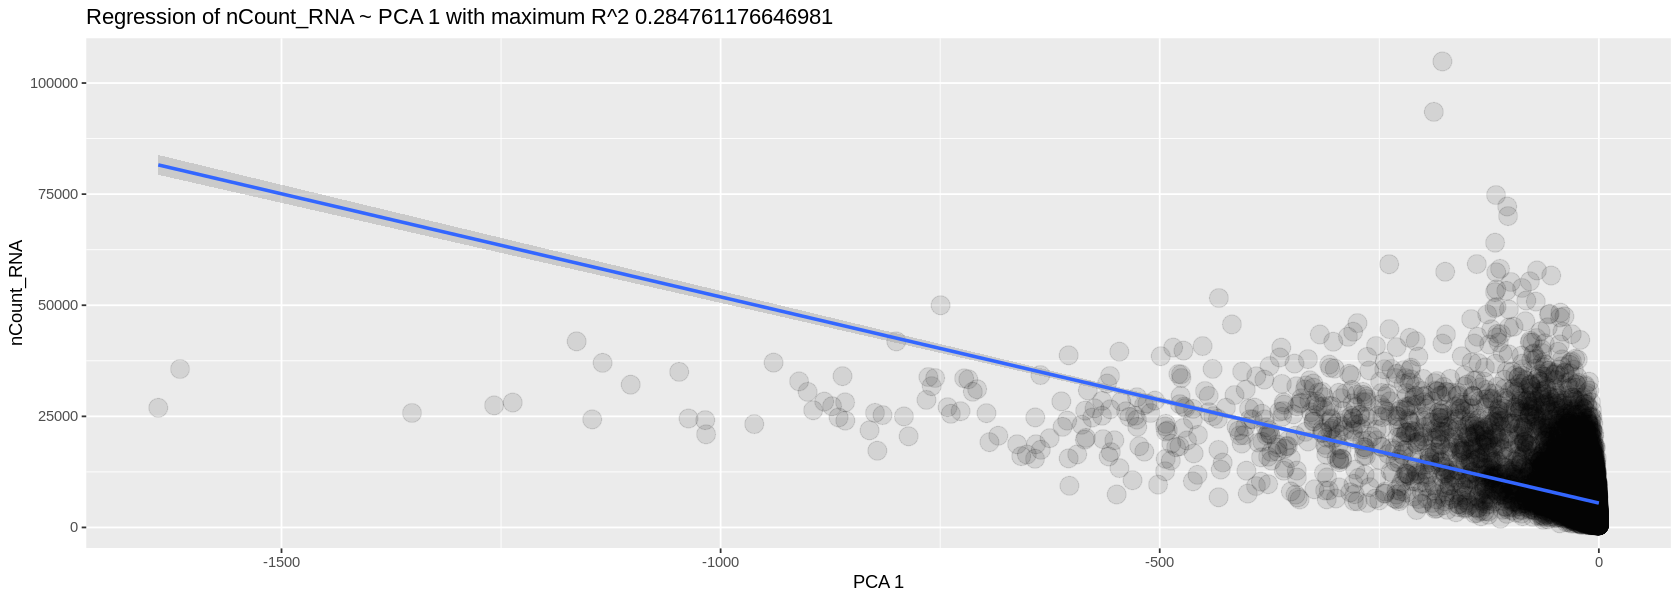

`geom_smooth()` using formula = 'y ~ x'


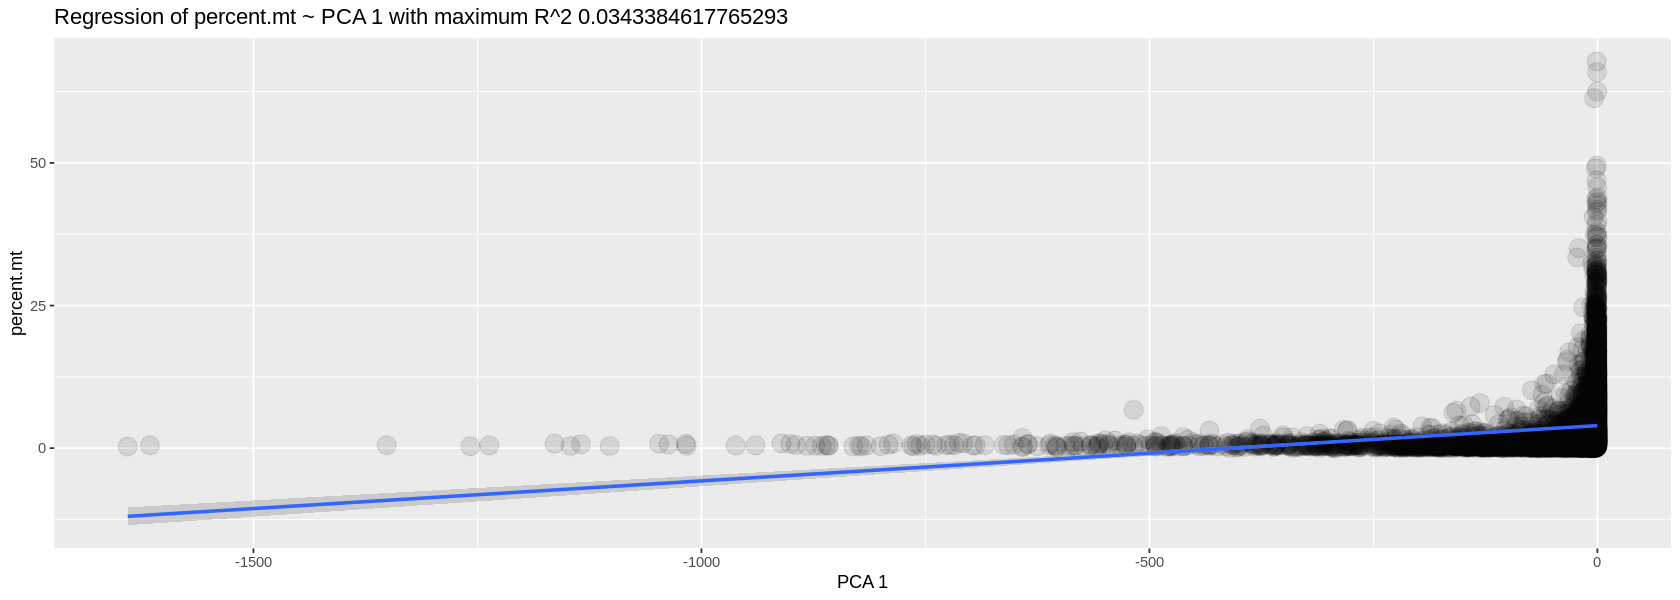

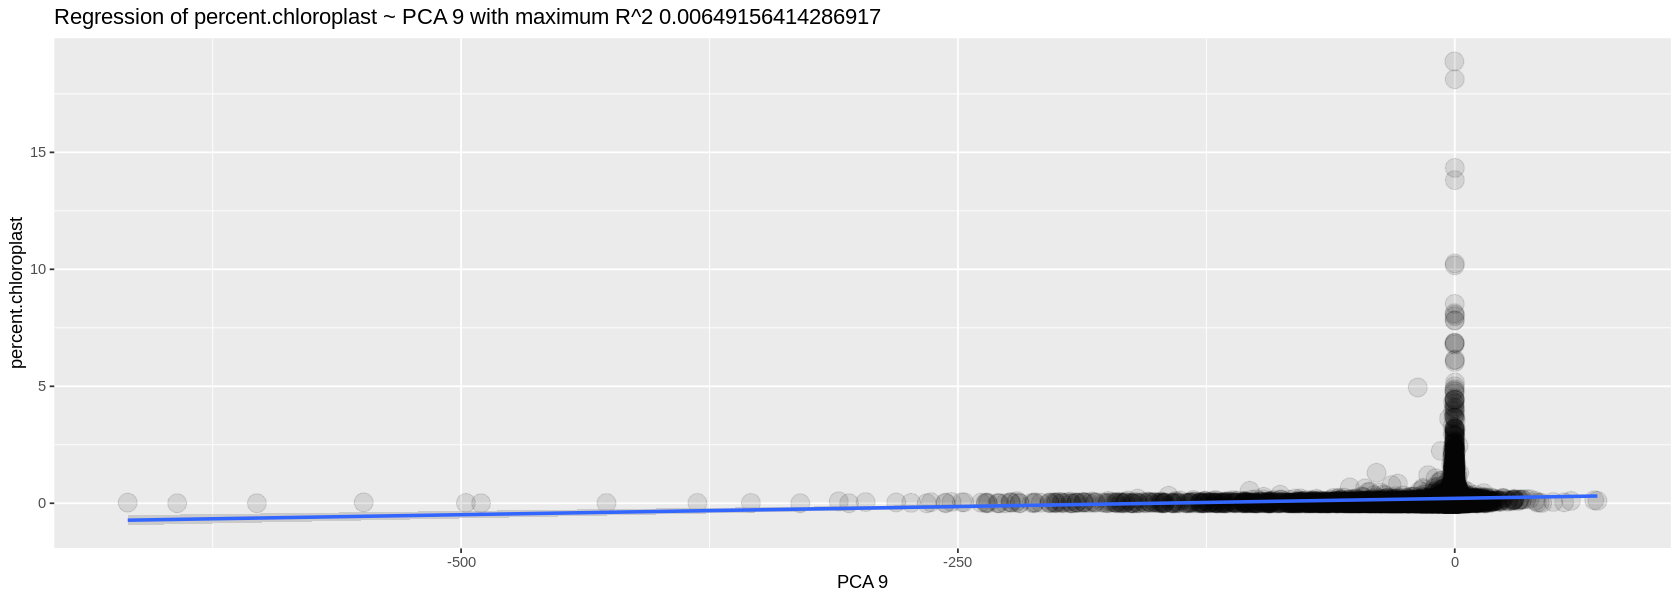

In [47]:
plotCorrelations( object=WT_Control1_10dpi_seurat, measures=c('nCount_RNA', 'percent.mt', 'percent.chloroplast') )

### Executing normalization

We simply run `SCtransform` below. Here you can choose to subsample some cells to do the normalization (`ncells` option): this is useful or you end up waiting for a long time. A few thousands cells is enough. You can also choose how many genes to use for normalization: here a high value is fine. The default is only 2000, but it might not be enough because so many genes contain useful information to normalize data, so keeping a high value is definitely good.

Normalized data is in the object `WT_Control1_10dpi_seurat_norm`.

In [58]:
variance_genes <- apply( as.matrix(WT_Control1_10dpi_seurat_filt[['RNA']]@counts), 1, var)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3289 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


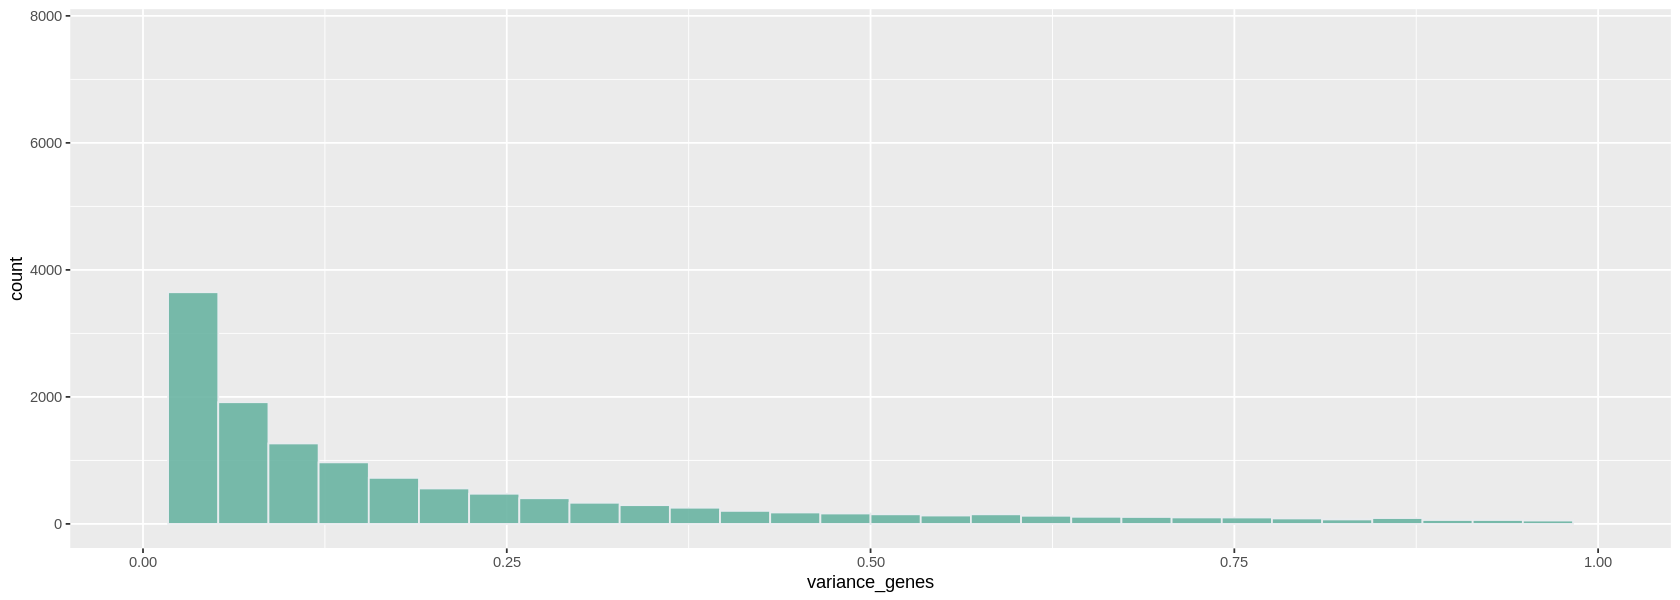

In [76]:
options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(data.frame(variance_genes), aes(variance_genes)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) + xlim(0,1)

plot1

In [79]:
sum( variance_genes > .25 )

[1] 6652

In [80]:
WT_Control1_10dpi_seurat_norm <- SCTransform(WT_Control1_10dpi_seurat_filt, 
                                             return.only.var.genes = FALSE, 
                                             ncells = 3000, 
                                             variable.features.n = sum( variance_genes > .25 ))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22682 by 8010

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 88 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22682 genes



  |======================================================================| 100%


Computing corrected count matrix for 22682 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.102557 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



### Visualizing the result

Now we plot the UMAP plot of the data to see how it looks like after normalizing. Before that we find the most relevant genes and calculate the PCA

In [81]:
WT_Control1_10dpi_seurat_norm <- FindVariableFeatures(WT_Control1_10dpi_seurat_norm)

In [82]:
WT_Control1_10dpi_seurat_norm <- RunPCA(object = WT_Control1_10dpi_seurat_norm, verbose = FALSE, seed.use = 123)

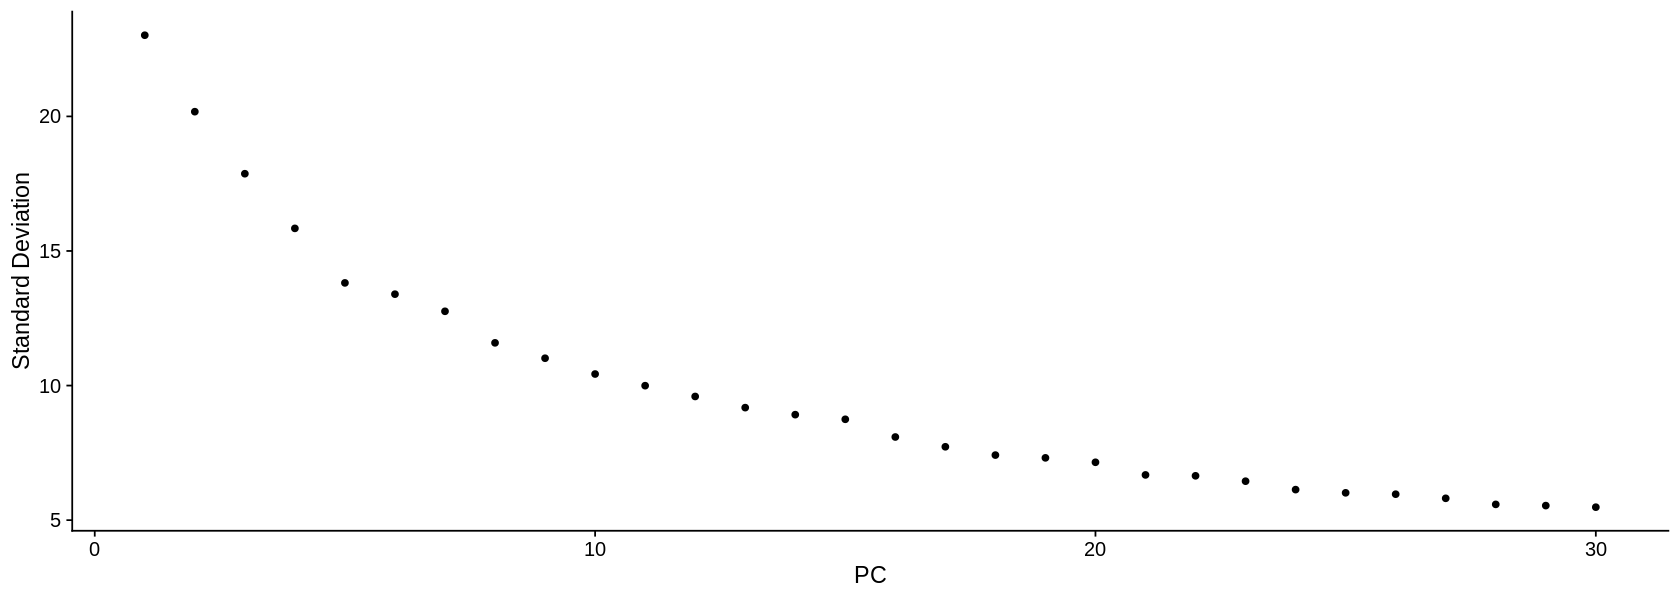

In [85]:
ElbowPlot(WT_Control1_10dpi_seurat_norm, ndims = 30)

We calculate UMAP (you need to do this only once)

In [95]:
WT_Control1_10dpi_seurat_norm <- RunUMAP(object = WT_Control1_10dpi_seurat_norm, a = .8, b=1,
                                         dims = 1:10, verbose = FALSE, seed.use = 123)

and we plot it. The result looks pretty neat and structured (we can clearly see there are various clusters).

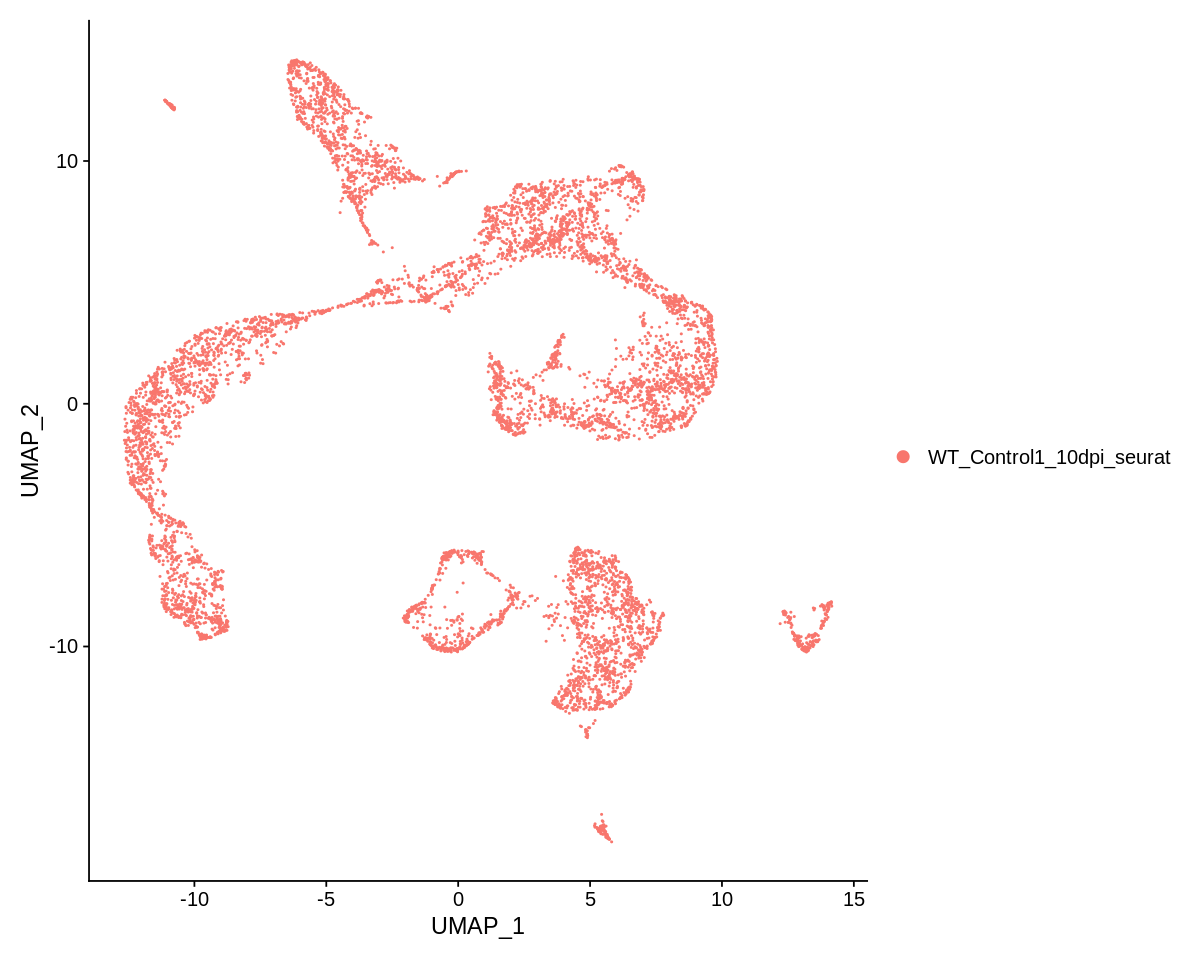

In [96]:
options(repr.plot.width=10, repr.plot.height=8)
UMAPPlot(object = WT_Control1_10dpi_seurat_norm)

## Removing doublets

Doublets removal is part of filtering, but it needs normalized data to work. This is why we do it after using `SCtransform`.

Doublets (and the very rare multiplets) refer to cells that **contain the transcriptional profiles of two or more distinct cells**. Doublets can occur during the cell dissociation process or when two or more cells are captured in the same droplet during the library preparation step.

It is quite obvious that a doublet transcriptional profile can confound downstream analyses, such as cell clustering and differential gene expression analysis. Most doublet detectors, like `DoubletFinder` which we will use, ** simulates doublets and then finds cells in the data which are similar to the simulated doublets**. Most such packages need an idea of the number/proportion of expected doublets in the dataset. **As indicated from the Chromium user guide, doublet rates are about as follows:**

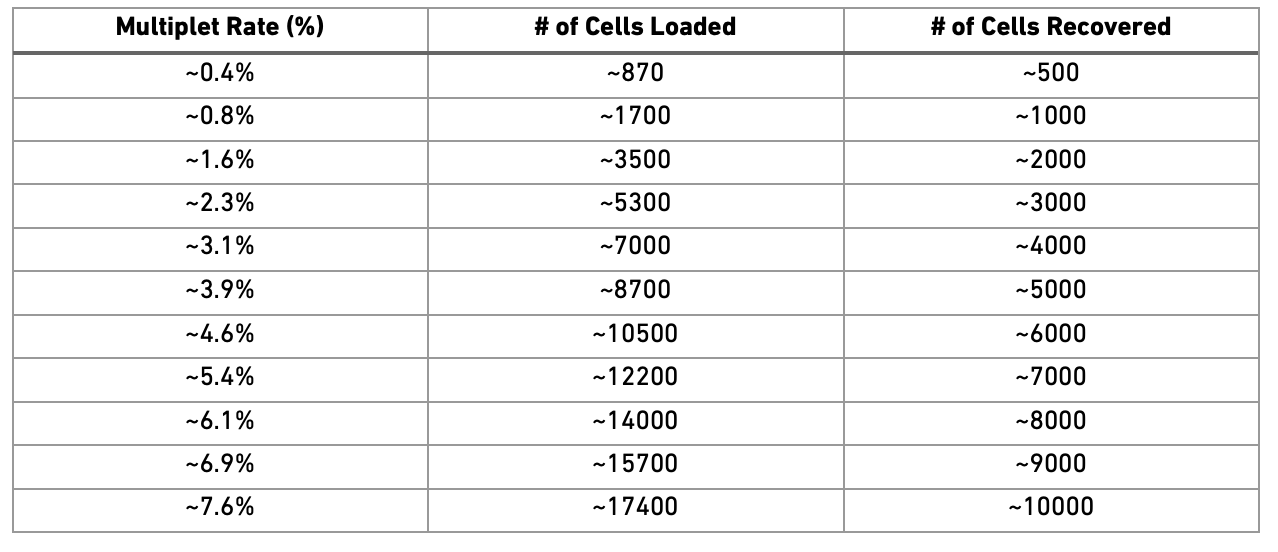

The data we are using contained about 10000 cells per sample (as in the knee plot at the beginning), hence we can assume that it originates from around 18000 loaded cells and should have a doublet rate at about 7.6%.

Note: Doublet prediction, like the rest of the filtering, **should be run on each sample separately**, especially if your different samples have different proportions of celltypes, conditions or sequencing depths.

Here, we will use `DoubletFinder` to predict doublet cells. The code takes some time to run, so be patient.

In [97]:
nExp <- round(ncol(WT_Control1_10dpi_seurat_norm) * 0.076)  # expected doublet rate

In [98]:
WT_Control1_10dpi_seurat_norm <- doubletFinder_v3(WT_Control1_10dpi_seurat_norm, 
                                                  pN = 0.25, #proportion of doublets to simulate)
                                                  pK = 0.09, 
                                                  nExp = nExp, 
                                                  PCs = 1:10, 
                                                  sct=T, 
                                                  workers=8, 
                                                  future.globals.maxSize = 8*1024^13,
                                                  seurat.ncells=3000)

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:stats4’:

    mle


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: future



[1] "Creating 2670 artificial doublets..."


Loading required package: sctransform



[1] "Creating Seurat object..."
[1] "Running SCTransform..."


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23388 by 10680

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 151 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23388 genes



  |======================================================================| 100%


Computing corrected count matrix for 23388 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.368957 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Running PCA..."


PC_ 1 
Positive:  LotjaGi2g1v0360900, LotjaGi5g1v0359500, LotjaGi6g1v0155900, LotjaGi6g1v0155800, LotjaGi3g1v0321700, LotjaGi3g1v0414900, LotjaGi3g1v0030500, LotjaGi5g1v0211100, LotjaGi3g1v0506700, LotjaGi4g1v0109600 
	   LotjaGi3g1v0009600, LotjaGi1g1v0539300, LotjaGi3g1v0450900, LotjaGi2g1v0269100, LotjaGi3g1v0010900, LotjaGi3g1v0530000, LotjaGi3g1v0373700, LotjaGi4g1v0137700, LotjaGi3g1v0380900, LotjaGi4g1v0309700 
	   LotjaGi1g1v0014300, LotjaGi5g1v0359400, LotjaGi6g1v0071000, LotjaGi3g1v0012400, LotjaGi3g1v0162300, LotjaGi3g1v0554100, LotjaGi1g1v0516900, LotjaGi2g1v0316800, LotjaGi2g1v0285600, LotjaGi2g1v0358600 
Negative:  LotjaGi6g1v0254300, LotjaGi3g1v0068000, LotjaGi6g1v0286800-LC, LotjaGi1g1v0080000, LotjaGi5g1v0005800, LotjaGi5g1v0269800-LC, LotjaGi5g1v0293100-LC, LotjaGi3g1v0222100, LotjaGi1g1v0006200, LotjaGi6g1v0254700 
	   LotjaGi3g1v0358300, LotjaGi3g1v0329100, LotjaGi3g1v0445300, LotjaGi1g1v0646500-LC, LotjaGi2g1v0157900, LotjaGi3g1v0505900, LotjaGi1g1v0022100, LotjaGi

[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


We visualize the UMAP plot and which cells are estimated doublets.

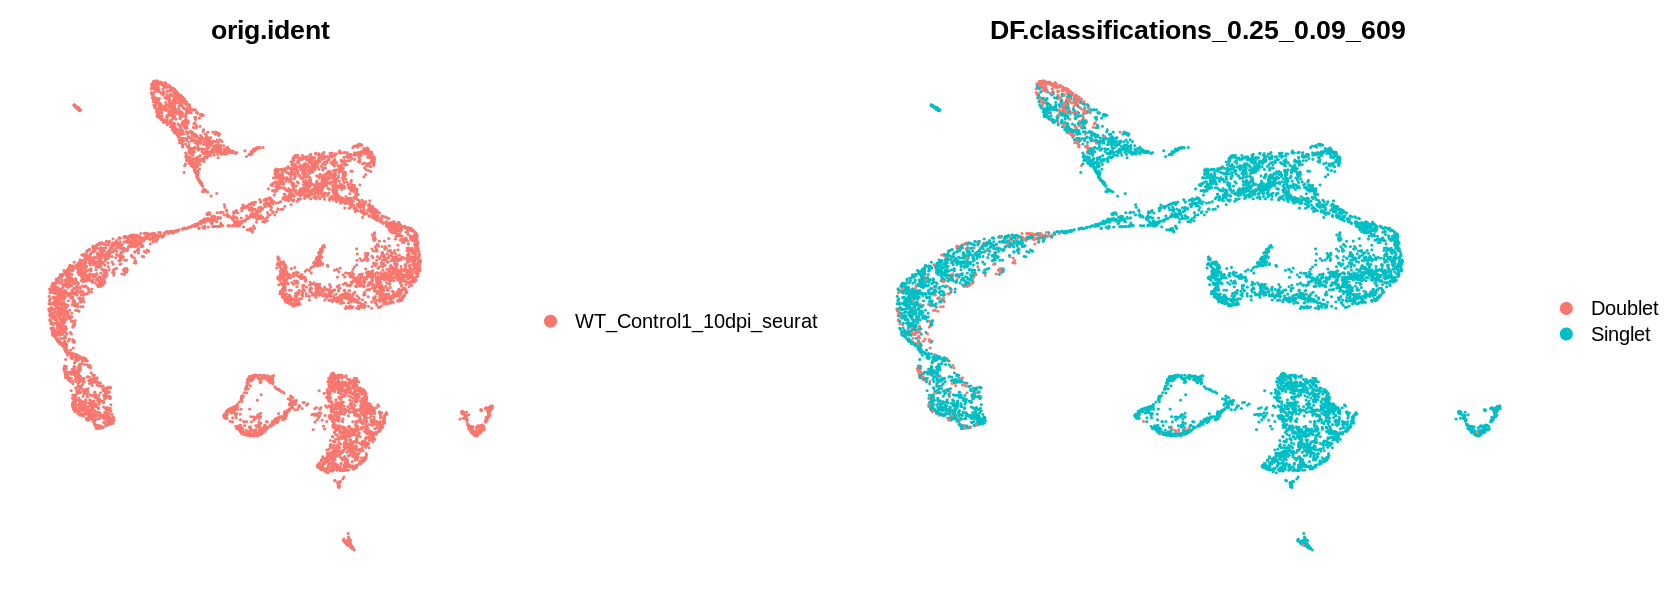

In [99]:
options(repr.plot.width=14, repr.plot.height=5)

DF.name = colnames(WT_Control1_10dpi_seurat_norm@meta.data)[grepl("DF.classification", colnames(WT_Control1_10dpi_seurat_norm@meta.data))]


cowplot::plot_grid(ncol = 2, DimPlot(WT_Control1_10dpi_seurat_norm, group.by = "orig.ident") + NoAxes(),
    DimPlot(WT_Control1_10dpi_seurat_norm, group.by = DF.name) + NoAxes())

Sometimes doublets have more detected genes than a single cell. In our case, some of the droplets have higher number of genes than the average (the red violin is large also above 3000 detected genes), so there is probably a portion of doublets. Of course we might remove some actual cells, but it is worth risking that and avoiding including the doublets.

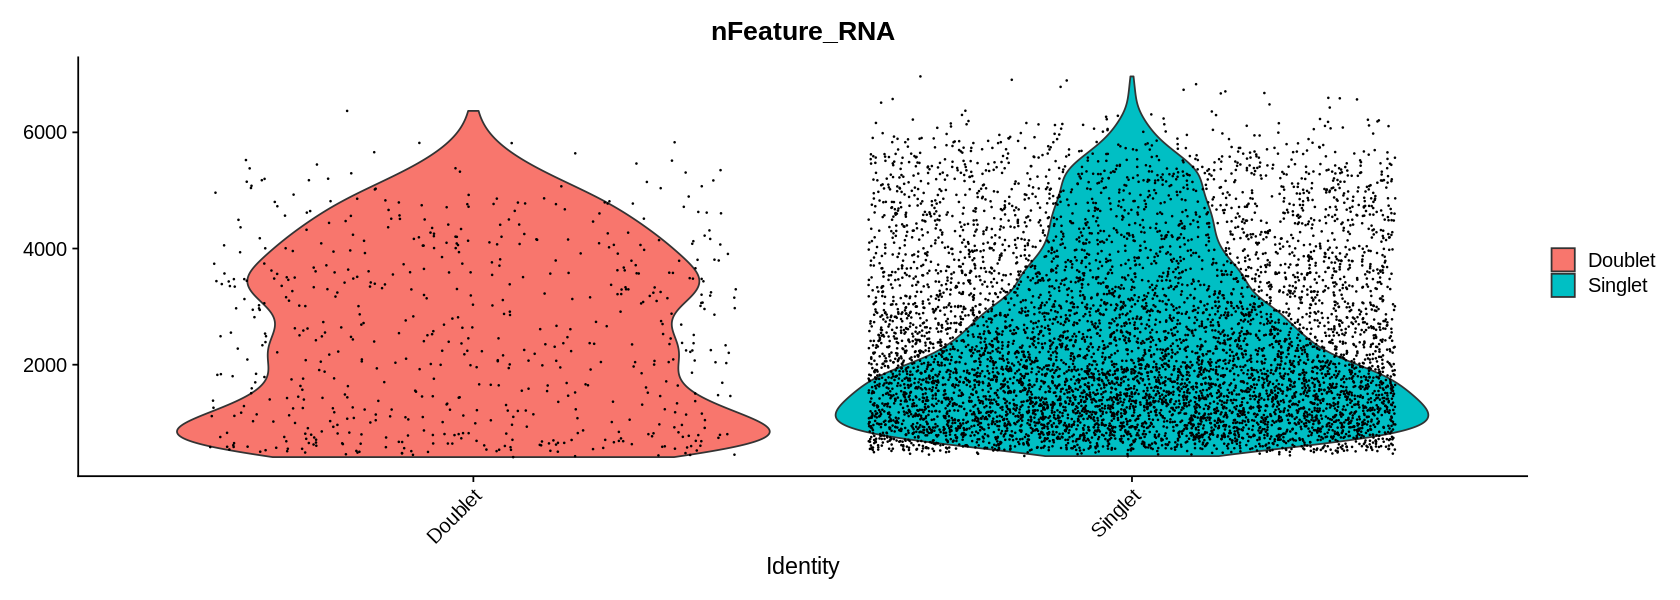

In [100]:
VlnPlot(WT_Control1_10dpi_seurat_norm, features = "nFeature_RNA", group.by = DF.name, pt.size = 0.1)

Here we remove the doublets.

In [101]:
WT_Control1_10dpi_seurat_norm = WT_Control1_10dpi_seurat_norm[, WT_Control1_10dpi_seurat_norm@meta.data[, DF.name] == "Singlet"]

We save our data after all the filtering work!

In [102]:
SaveH5Seurat(object = WT_Control1_10dpi_seurat_norm, 
             filename = "control1.normalized.h5Seurat", 
             overwrite = TRUE)

Warning message:
“Overwriting previous file control1.normalized.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



To read the data again, you need the command

`WT_Control1_10dpi_seurat_norm <- LoadH5Seurat("control1.normalized.h5Seurat")`

# Integration

Integration of scRNA-seq data is useful to combine datasets from different experimental conditions, in our case the wild-type vs infected, to gain a broader understanding of cellular processes. Integration is challenging due to technical variations and biological differences between the datasets.

To integrate scRNA-seq datasets, we have applyed **quality control and normalization to each sample** to ensure consistency and accuracy of the data. Datasets can now be integrated using various methods. Seurat uses **canonical correlation analysis (CCA)** to integrate scRNA-seq datasets from different experimental conditions. CCA identifies shared variation between two datasets while accounting for technical differences, such as batch effects.

The shared covariance patterns **can represent biological signals that are common across the datasets**, such as cell types or signaling pathways.

We load another control dataset, and two wild types. Those have been previously preprocessed, so you will not need to. Remember again: each dataset must be preprocessed separately before integration.

In [4]:
WT_Control1_10dpi_seurat_norm <- LoadH5Seurat("control1.normalized.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [5]:
WT_Control2_10dpi_seurat_filt <- LoadH5Seurat("control2.normalized.h5Seurat")
WT_Mloti1_10dpi_seurat_filt <- LoadH5Seurat("wildtype1.normalized.h5Seurat")
WT_Mloti2_10dpi_seurat_filt <- LoadH5Seurat("wildtype2.normalized.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pc

To integrate the datasets, we need to start creating a list with all datasets.

In [6]:
Gifu.list <- list(WT_Control1_10dpi_seurat_norm, 
                  WT_Control2_10dpi_seurat_filt, 
                  WT_Mloti1_10dpi_seurat_filt, 
                  WT_Mloti2_10dpi_seurat_filt)

We then start by normalizing each dataset in the list with `SCtransform`. Here we also have a commented command (with the symbol `#`) that is not executed, to show how you add technical variations to remove, if necessary (this is not the case of the tutorial, but might happen with your data).

In [7]:
Gifu.list <- lapply(X = Gifu.list, FUN = function(x) {
  #x <- SCTransform(x, vars.to.regress = c("percent.mt",  "percent.chloroplast"), verbose = TRUE)
  x <- SCTransform(x, verbose = TRUE, ncells=3000)
})

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22528 by 7401

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 125 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22528 genes



  |======================================================================| 100%


Computing corrected count matrix for 22528 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.03705 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21689 by 4005

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 114 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21689 genes



  |======================================================================| 100%


Computing corrected count matrix for 21689 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 49.12803 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21520 by 6407

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 131 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21520 genes



  |======================================================================| 100%


Computing corrected count matrix for 21520 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 50.6687 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20089 by 3556

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 139 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20089 genes



  |======================================================================| 100%


Computing corrected count matrix for 20089 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 37.3734 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Now we apply the CCA (Canonical Correlation Analysis) to put datasets together according to their similarities, while removing differences. The number of genes to use during integration is expressed below as `nfeatures`.

In [8]:
for(x in Gifu.list){
  variances <- apply(x[['RNA']]@counts, 1, var)
  cat('N genes with variance above in dataset: ')
  cat( sum(variances>.1) )
  cat('\n')
}

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


N genes with variance above in dataset: 9974
N genes with variance above in dataset: 10277


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


N genes with variance above in dataset: 5619
N genes with variance above in dataset: 5744


In [9]:
Gifu.features <- SelectIntegrationFeatures(object.list = Gifu.list, nfeatures = 10277)

Gifu.list <- PrepSCTIntegration(object.list = Gifu.list, anchor.features = Gifu.features)

In [10]:
Gifu.anchors <- FindIntegrationAnchors(object.list = Gifu.list, normalization.method = "SCT", 
                                       anchor.features = Gifu.features, reference = c(1,2))

seurat.integrated <- IntegrateData(anchorset = Gifu.anchors, normalization.method = "SCT")

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12625 anchors

Filtering anchors

	Retained 12528 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12780 anchors

Filtering anchors

	Retained 12141 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10035 anchors

Filtering anchors

	Retained 9460 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10362 anchors

Filtering anchors

	Retained 10181 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8765 anchors

Filtering anchors

	Retained 8610 anchors

Building integrated reference

Merging dataset 2 into 1

Extracting anchors for merged samples

F

In [11]:
cat("The default assay of the data is now called: ")
cat(DefaultAssay(seurat.integrated))

The default assay of the data is now called: integrated

We need recalculate UMAP to look at all datasets integrated together

In [12]:
seurat.integrated <- RunPCA(object = seurat.integrated, verbose = FALSE)

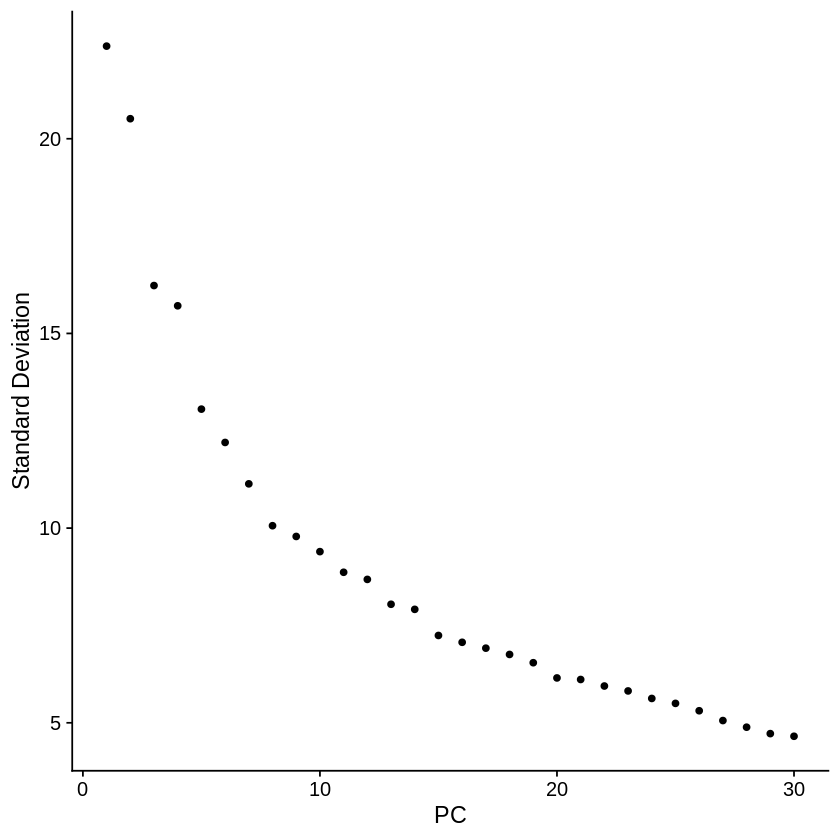

In [13]:
ElbowPlot(seurat.integrated, ndims = 30)

In [14]:
seurat.integrated <- FindNeighbors(object = seurat.integrated, dims = 1:10, k.param = 5)

Computing nearest neighbor graph

Computing SNN



In [15]:
#UMAP and tsne
seurat.integrated <- RunUMAP(object = seurat.integrated, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:23:20 UMAP embedding parameters a = 0.9922 b = 1.112

12:23:20 Read 21369 rows and found 10 numeric columns

12:23:20 Using Annoy for neighbor search, n_neighbors = 30

12:23:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:23:23 Writing NN index file to temp file /tmp/RtmpHfTQtq/file157c4ed9ccec

12:23:23 Searching Annoy index using 8 threads, search_k = 3000

12:23:24 Annoy recall = 100%

12:23:25 Commencing smooth kNN distance calibration using 8 threads
 with target n_neighbor

We do also a clustering of the data. The resolution is used to change the number of clusters. We do not need many, so we set on to 0.5.

In [28]:
#Clustering using Louvain algorithm
seurat.integrated <- FindClusters(object = seurat.integrated, resolution = .25)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21369
Number of edges: 180442

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9628
Number of communities: 19
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


The clusters are saved in the meta data table as `integrated_snn_res.0.5`. Note that the name changes with the resolution.

In [29]:
head( seurat.integrated@meta.data )

nCount_RNA nFeature_RNA orig.ident               Condition
AAACCCAAGGGCAGTT-1_1  3567      1919         WT_Control1_10dpi_seurat Control  
AAACCCACATGATCTG-1_1 20942      4711         WT_Control1_10dpi_seurat Control  
AAACCCAGTAGCTTGT-1_1 29105      5157         WT_Control1_10dpi_seurat Control  
AAACCCAGTCTCTCAC-1_1  6115      2124         WT_Control1_10dpi_seurat Control  
AAACCCATCACCTTGC-1_1  7410      2988         WT_Control1_10dpi_seurat Control  
AAACGAAAGTCCTGTA-1_1  5616      2034         WT_Control1_10dpi_seurat Control  
                     percent.mt percent.chloroplast nCount_SCT nFeature_SCT
AAACCCAAGGGCAGTT-1_1 4.6818054  0.02803476          4618       1919        
AAACCCACATGATCTG-1_1 0.4775093  0.12415242          4990       2158        
AAACCCAGTAGCTTGT-1_1 0.2954819  0.05497337          4988       2134        
AAACCCAGTCTCTCAC-1_1 1.6026165  0.01635323          5624       2124        
AAACCCATCACCTTGC-1_1 0.5263158  0.09446694          5891       2986        
AAACGAAAGTCCTGTA-1_1 0.7122507  0.10683761          5501       2034        
                     pANN_0.25_0.09_609 DF.classifications_0.25_0.09_609
AAACCCAAGGGCAGTT-1_1 0.1810614          Singlet                         
AAACCCACATGATCTG-1_1 0.2278876          Singlet                         
AAACCCAGTAGCTTGT-1_1 0.2601457          Singlet                         
AAACCCAGTCTCTCAC-1_1 0.1841831          Singlet                         
AAACCCATCACCTTGC-1_1 0.2455775          Singlet                         
AAACGAAAGTCCTGTA-1_1 0.2133195          Singlet                         
                     pANN_0.25_0.09_329 DF.classifications_0.25_0.09_329
AAACCCAAGGGCAGTT-1_1 NA                 NA                              
AAACCCACATGATCTG-1_1 NA                 NA                              
AAACCCAGTAGCTTGT-1_1 NA                 NA                              
AAACCCAGTCTCTCAC-1_1 NA                 NA                              
AAACCCATCACCTTGC-1_1 NA                 NA                              
AAACGAAAGTCCTGTA-1_1 NA                 NA                              
                     pANN_0.25_0.09_309 DF.classifications_0.25_0.09_309
AAACCCAAGGGCAGTT-1_1 NA                 NA                              
AAACCCACATGATCTG-1_1 NA                 NA                              
AAACCCAGTAGCTTGT-1_1 NA                 NA                              
AAACCCAGTCTCTCAC-1_1 NA                 NA                              
AAACCCATCACCTTGC-1_1 NA                 NA                              
AAACGAAAGTCCTGTA-1_1 NA                 NA                              
                     pANN_0.25_0.09_110 DF.classifications_0.25_0.09_110
AAACCCAAGGGCAGTT-1_1 NA                 NA                              
AAACCCACATGATCTG-1_1 NA                 NA                              
AAACCCAGTAGCTTGT-1_1 NA                 NA                              
AAACCCAGTCTCTCAC-1_1 NA                 NA                              
AAACCCATCACCTTGC-1_1 NA                 NA                              
AAACGAAAGTCCTGTA-1_1 NA                 NA                              
                     integrated_snn_res.0.5 seurat_clusters
AAACCCAAGGGCAGTT-1_1 12                     0              
AAACCCACATGATCTG-1_1 4                      7              
AAACCCAGTAGCTTGT-1_1 6                      9              
AAACCCAGTCTCTCAC-1_1 5                      1              
AAACCCATCACCTTGC-1_1 7                      12             
AAACGAAAGTCCTGTA-1_1 23                     15             
                     integrated_snn_res.0.25
AAACCCAAGGGCAGTT-1_1 0                      
AAACCCACATGATCTG-1_1 7                      
AAACCCAGTAGCTTGT-1_1 9                      
AAACCCAGTCTCTCAC-1_1 1                      
AAACCCATCACCTTGC-1_1 12                     
AAACGAAAGTCCTGTA-1_1 15

Now we look at UMAP

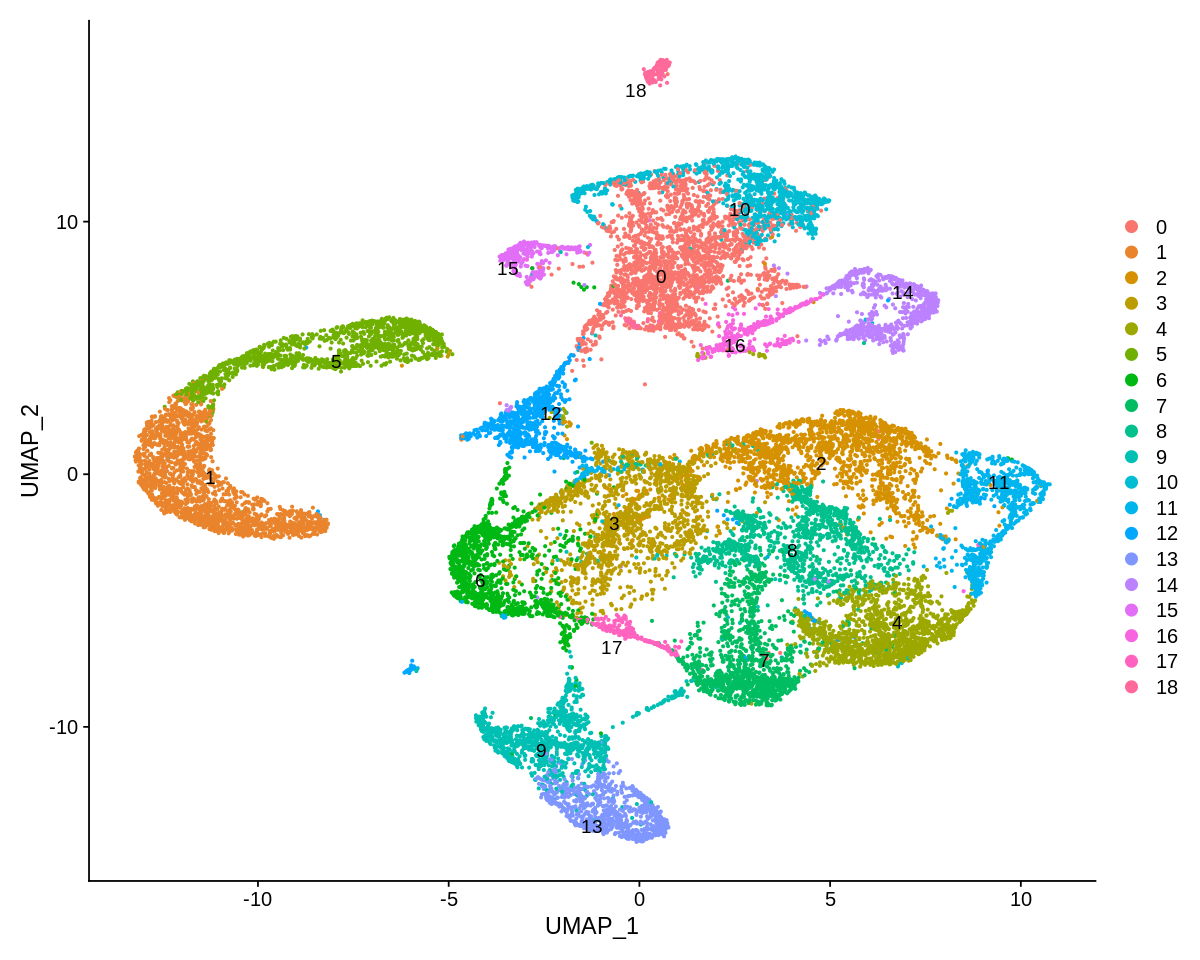

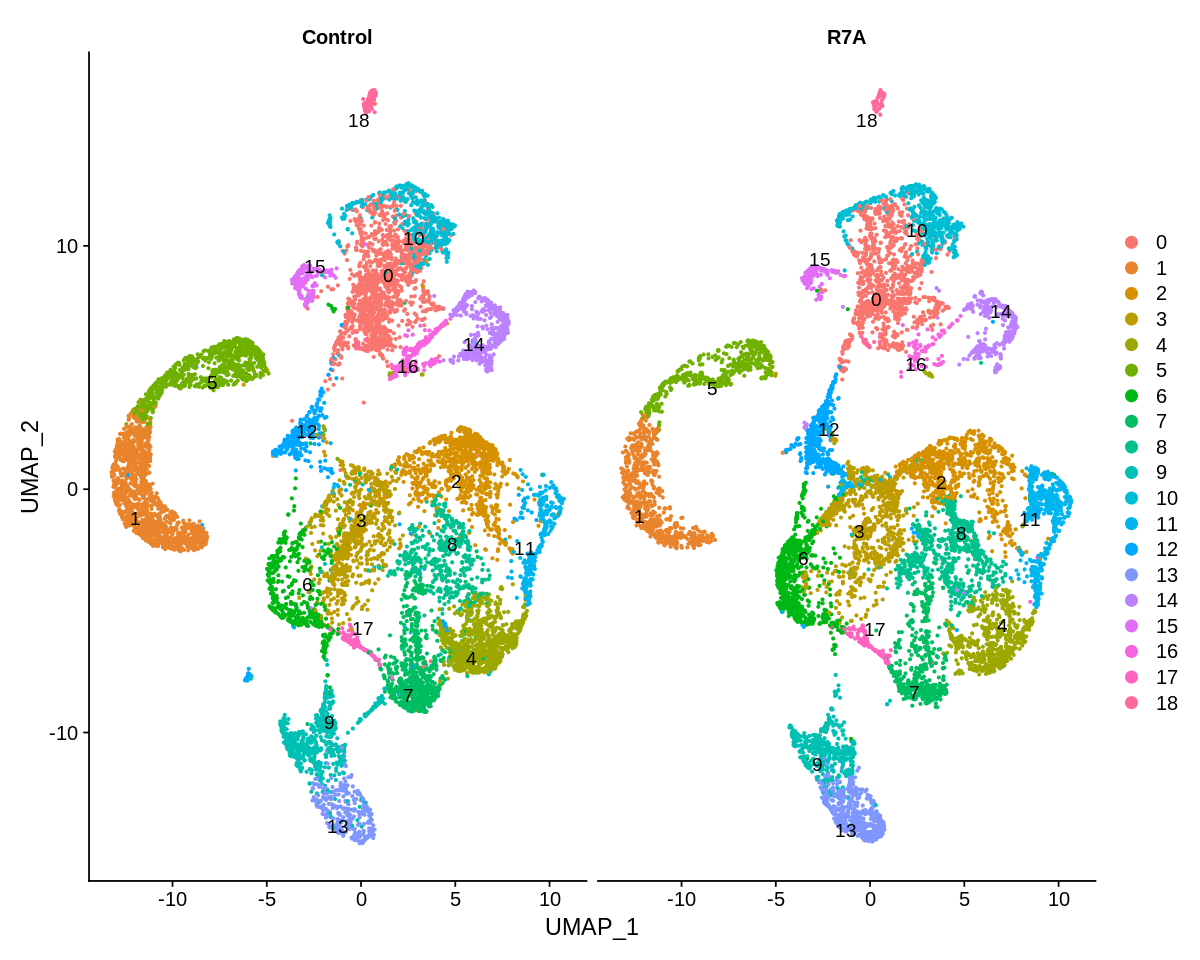

In [30]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5, split.by = "Condition")

and we save our integrated data

In [31]:
SaveH5Seurat(object = seurat.integrated, filename = "seurat.integrated.h5Seurat", overwrite=TRUE)

Warning message:
“Overwriting previous file seurat.integrated.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



# Assign cell types using markers

One way to assign cell types is to use known markers for various cell types. Here we use some of them from the long list of markers in the file `Cell_type_markers.csv`. Download it on our laptop if you want to look at it and use other markers in your own data.

In [49]:
seurat.clustered <-  LoadH5Seurat("seurat.integrated.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph integrated_nn

Adding graph integrated_snn

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”


In [120]:
features_list <- list(
    'Cortex_scoring' = c("LotjaGi1g1v0006200",
                 "LotjaGi1g1v0022100",
                 "LotjaGi1g1v0261700",
                 "LotjaGi1g1v0348000",
                 "LotjaGi2g1v0303000",
                 "LotjaGi3g1v0505900"),
    'Epidermis_scoring' = c("LotjaGi1g1v0080000",
                    "LotjaGi1g1v0377600",
                    "LotjaGi1g1v0613100",
                    "LotjaGi3g1v0070500"),
    'Endodermis_scoring' = c("LotjaGi1g1v0114400",
                     "LotjaGi1g1v0221300",
                     "LotjaGi1g1v0240900-LC",
                     "LotjaGi1g1v0707500"), 
    'RootCap_scoring' = c("LotjaGi1g1v0020900",
                   "LotjaGi1g1v0039700-LC",
                   "LotjaGi1g1v0040300",
                   "LotjaGi1g1v0147500"),  
    'Meristem_scoring'= c("LotjaGi4g1v0300900",
                         "LotjaGi6g1v0056500",
                         "LotjaGi1g1v0594200"),
    'Phloem_scoring'= c("LotjaGi1g1v0028800",
                "LotjaGi1g1v0085900",
                "LotjaGi1g1v0119300",
                "LotjaGi1g1v0149100"),
    'QuiescentCenter_scoring' = c("LotjaGi1g1v0004300",
                           "LotjaGi1g1v0021400",
                           "LotjaGi1g1v0052700",
                           "LotjaGi1g1v0084000"),
    'RootHair_scoring'= c("LotjaGi1g1v0014300",
                   "LotjaGi1g1v0109000",
                   "LotjaGi1g1v0109100",
                   "LLotjaGi1g1v0143900"),  
    'Pericycle_scoring'= c("LotjaGi3g1v0222100",
                   "LotjaGi3g1v0395900-LC",
                   "LotjaGi5g1v0166000-LC",
                   "LotjaGi3g1v0395500-LC",
                   "LotjaGi1g1v0783700-LC",
                   "LotjaGi2g1v0333200",
                   "LotjaGi4g1v0293000-LC"),     
    'Stele_scoring' = c("LotjaGi2g1v0126700",
                "LotjaGi1g1v0558200",
                "LotjaGi4g1v0215500",
                "LotjaGi3g1v0174100",
                "LotjaGi5g1v0288600",
                "LotjaGi3g1v0129700"),
    'Xylem_scoring' = c("LotjaGi1g1v0623100",
                "LotjaGi1g1v0569300",
                "LotjaGi1g1v0443000",
                "LotjaGi1g1v0428800")
    )

In [125]:
seurat.clustered <- AddModuleScore(
  object = seurat.clustered,
  features = features_list,
  ctrl = 5,
  name = 'LJ_scores'
)

Warning message:
“The following features are not present in the object: LLotjaGi1g1v0143900, not searching for symbol synonyms”


In [126]:
L <- length(names(seurat.clustered@meta.data))
F <- length(names(features_list))-1
newnames <- names(seurat.clustered@meta.data)
newnames[(L-F):L] <- names(features_list)
names(seurat.clustered@meta.data) <- newnames
for(N in names(seurat.clustered@meta.data)[(L-F):L])
    seurat.clustered@meta.data[N] <- seurat.clustered@meta.data[N] / max(seurat.clustered@meta.data[N])

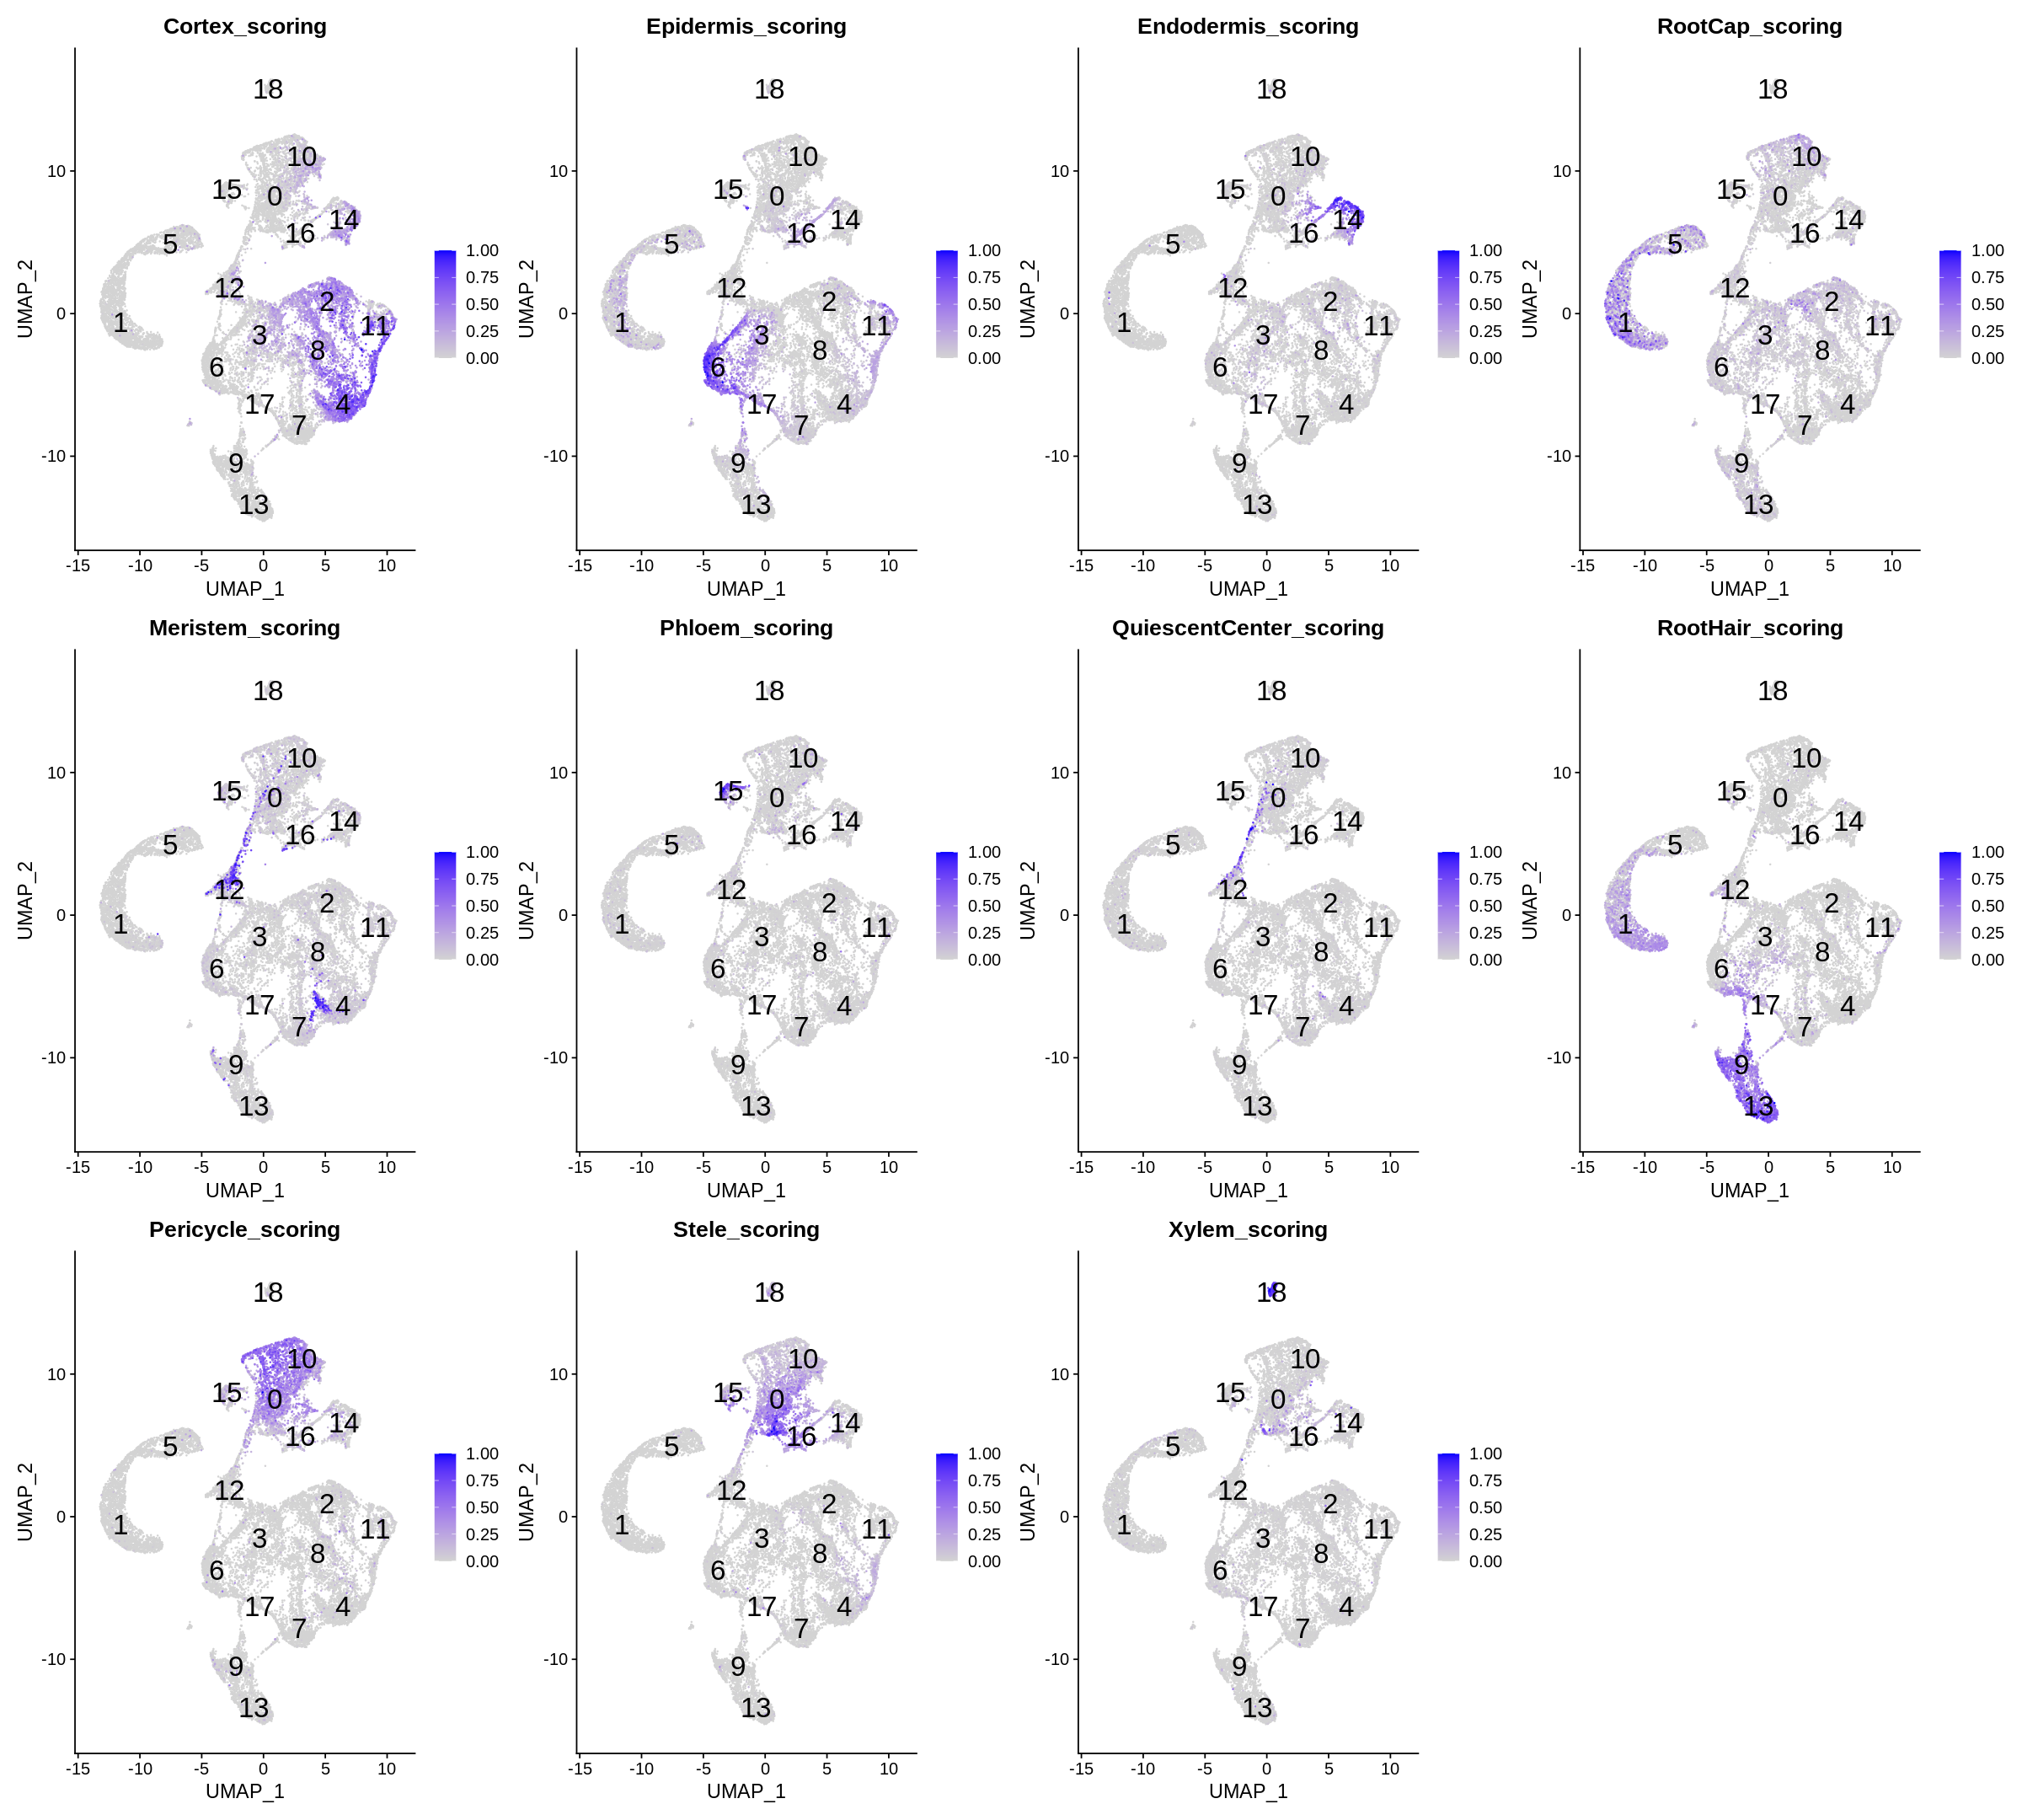

In [127]:
options(repr.plot.width=20, repr.plot.height=18)

FeaturePlot(seurat.clustered, 
            reduction = "umap", 
            features = names(features_list), 
            order = TRUE,
            min.cutoff = 0,
            label = TRUE, 
            label.size = 7) + theme(legend.position = "right")

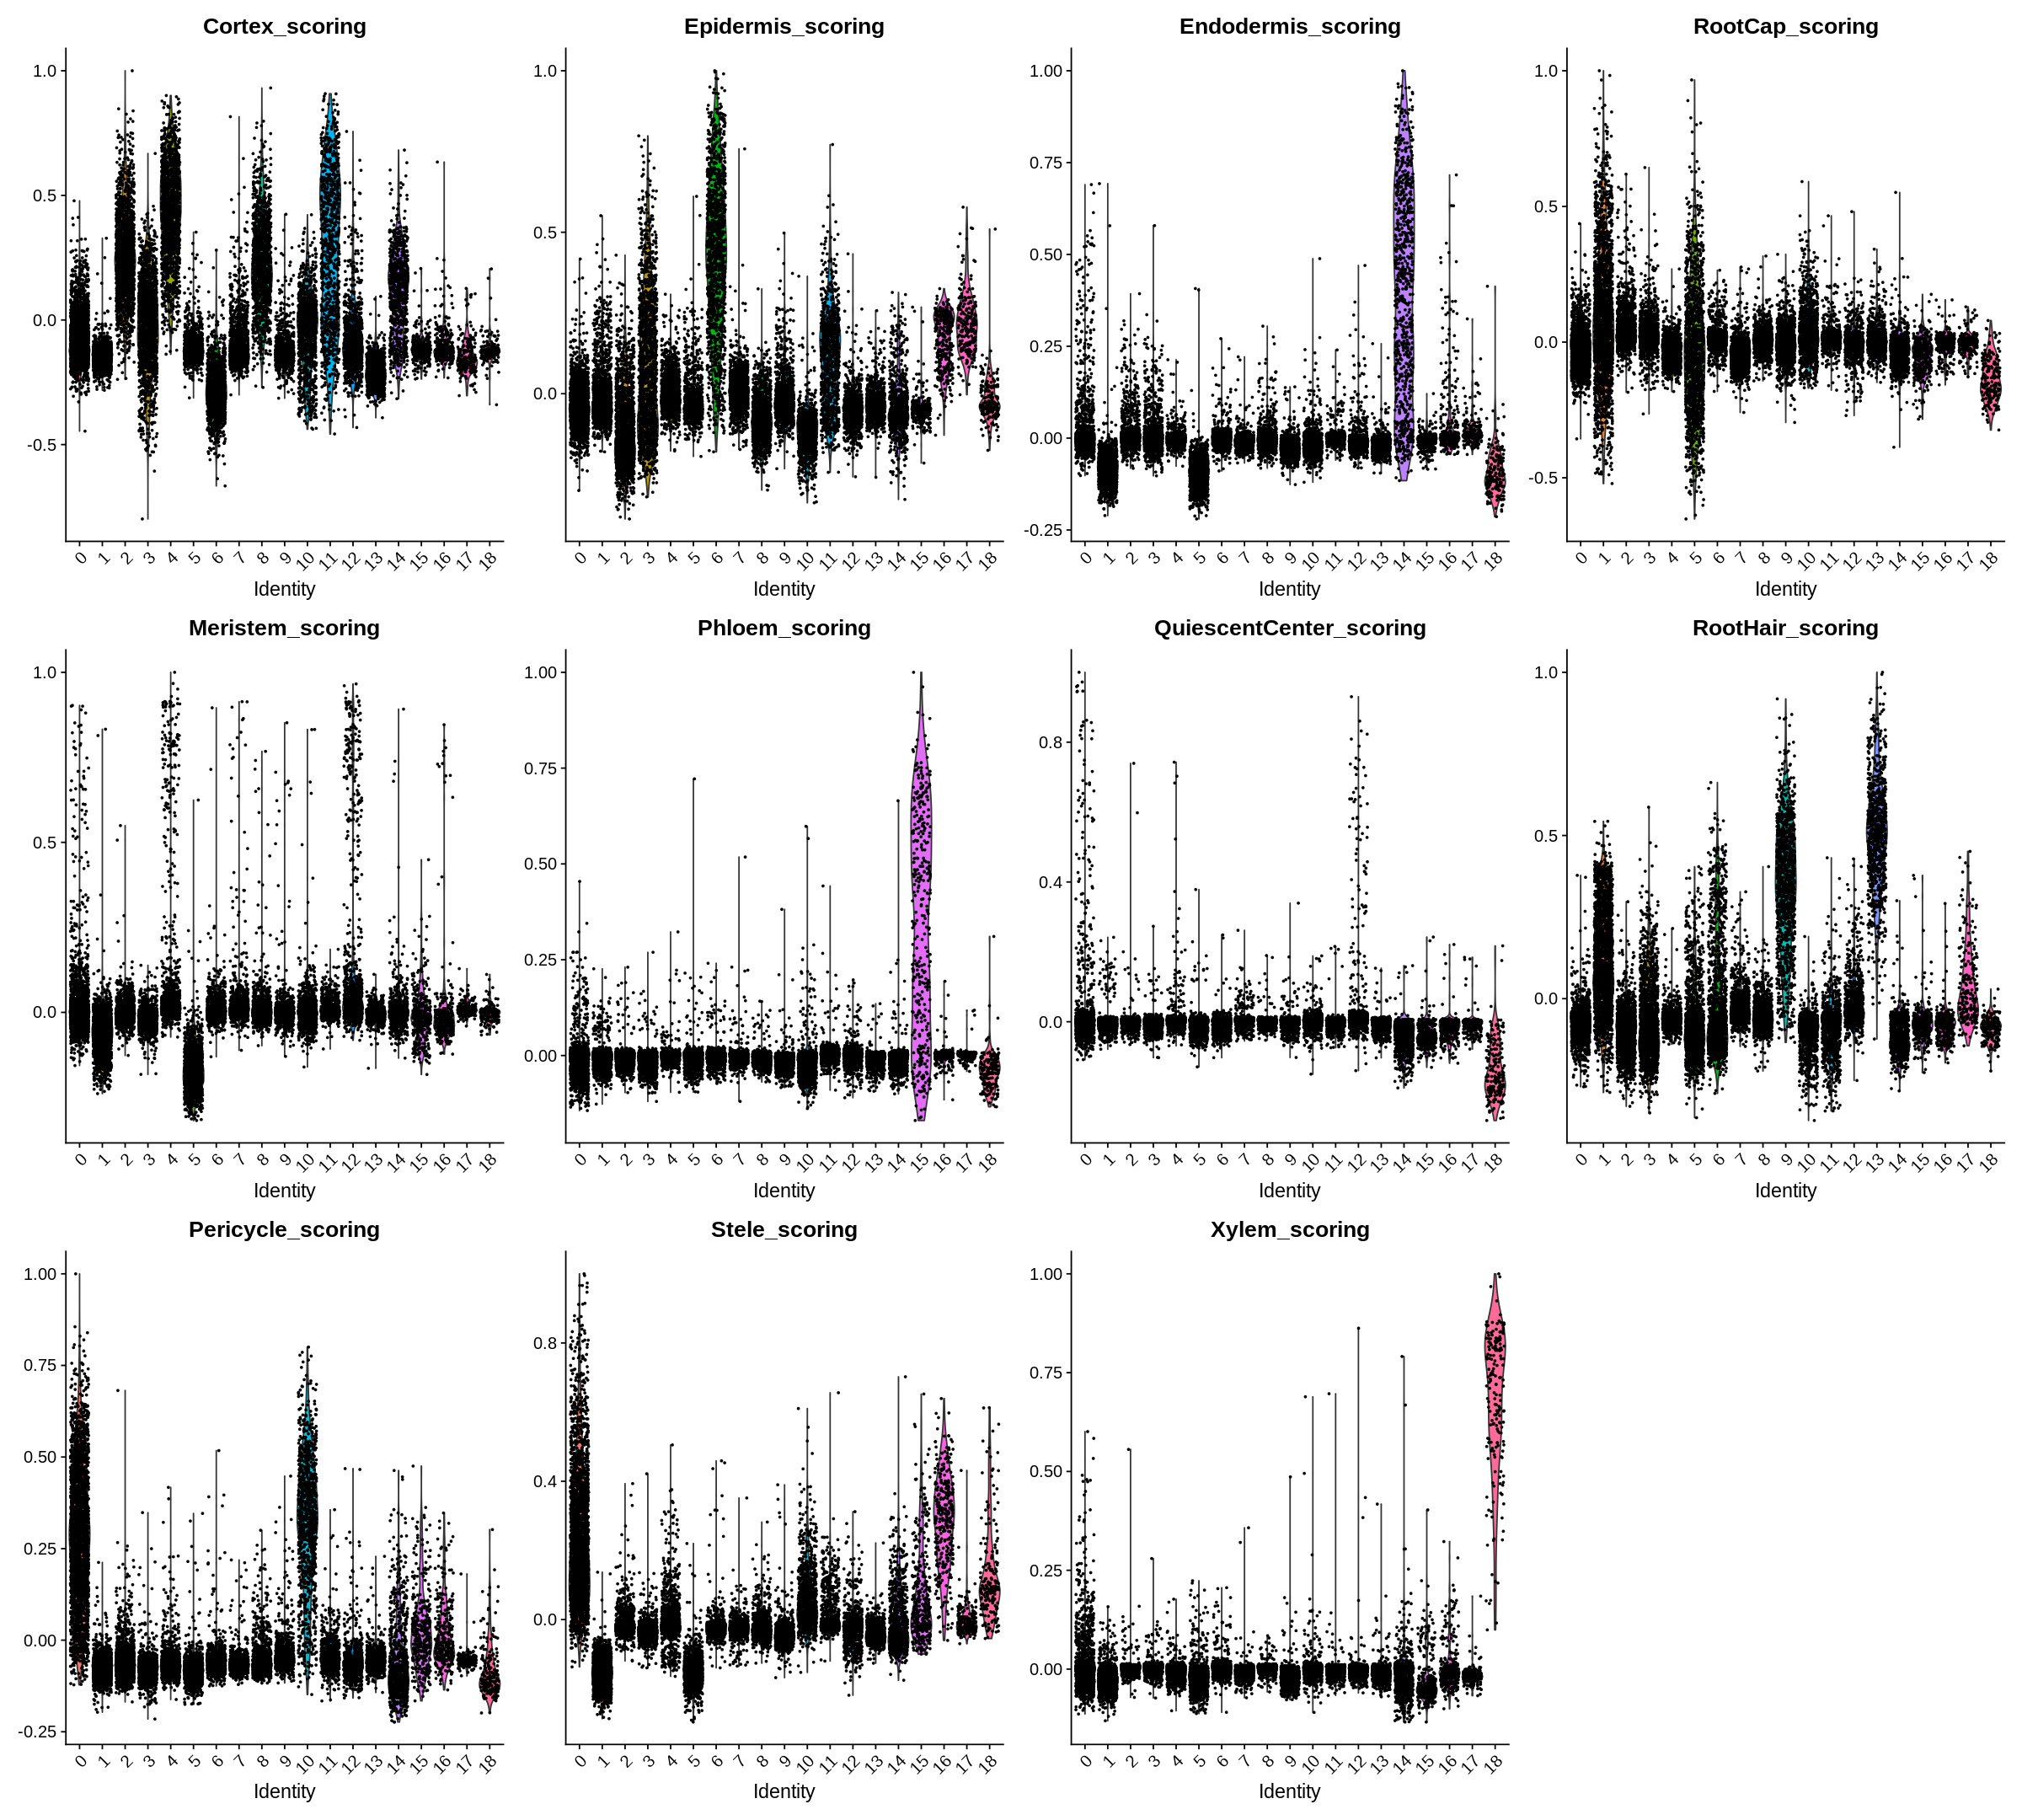

In [128]:
VlnPlot(seurat.clustered,  group.by = 'integrated_snn_res.0.25', features = names(features_list))

## Cluster assignment from visualized marker scores

After looking at the plots above we rename the numbered clusters into cell types. Do this yourself as an exercise using the example command `RenameIdents` below (sometimes clusters change and the names used here might not mach anymore the cluster numbers).

In [129]:
#Rename the clusters based on the cell type markers 

Idents(seurat.clustered) <- 'integrated_snn_res.0.25'
seurat.clustered <- RenameIdents(object = seurat.clustered,
                               "2"="Cortex", "8"="Cortex", "4"="Cortex", "11"="Cortex",
                               "6"="Epidermis",
                               "14"="Endodermis",  
                               "1"="Root_Cap", "5"="Root_Cap",
                               "15"="Phloem",
                               "9"="Root_Hair", "13"="Root_Hair",
                               "0"="Pericycle_Stele", "10"="Pericycle",
                               "16"="Stele",
                               "18"="Xylem")

The names are saved in `seurat.integrated@active.ident` (the active clustering used in analysis), but we save them also in the metadata as `Cell_types`:

In [130]:
seurat.clustered@meta.data$Cell_types <- Idents(seurat.clustered)

It seems we named most clusters. For some others we could not really be sure of the markers.

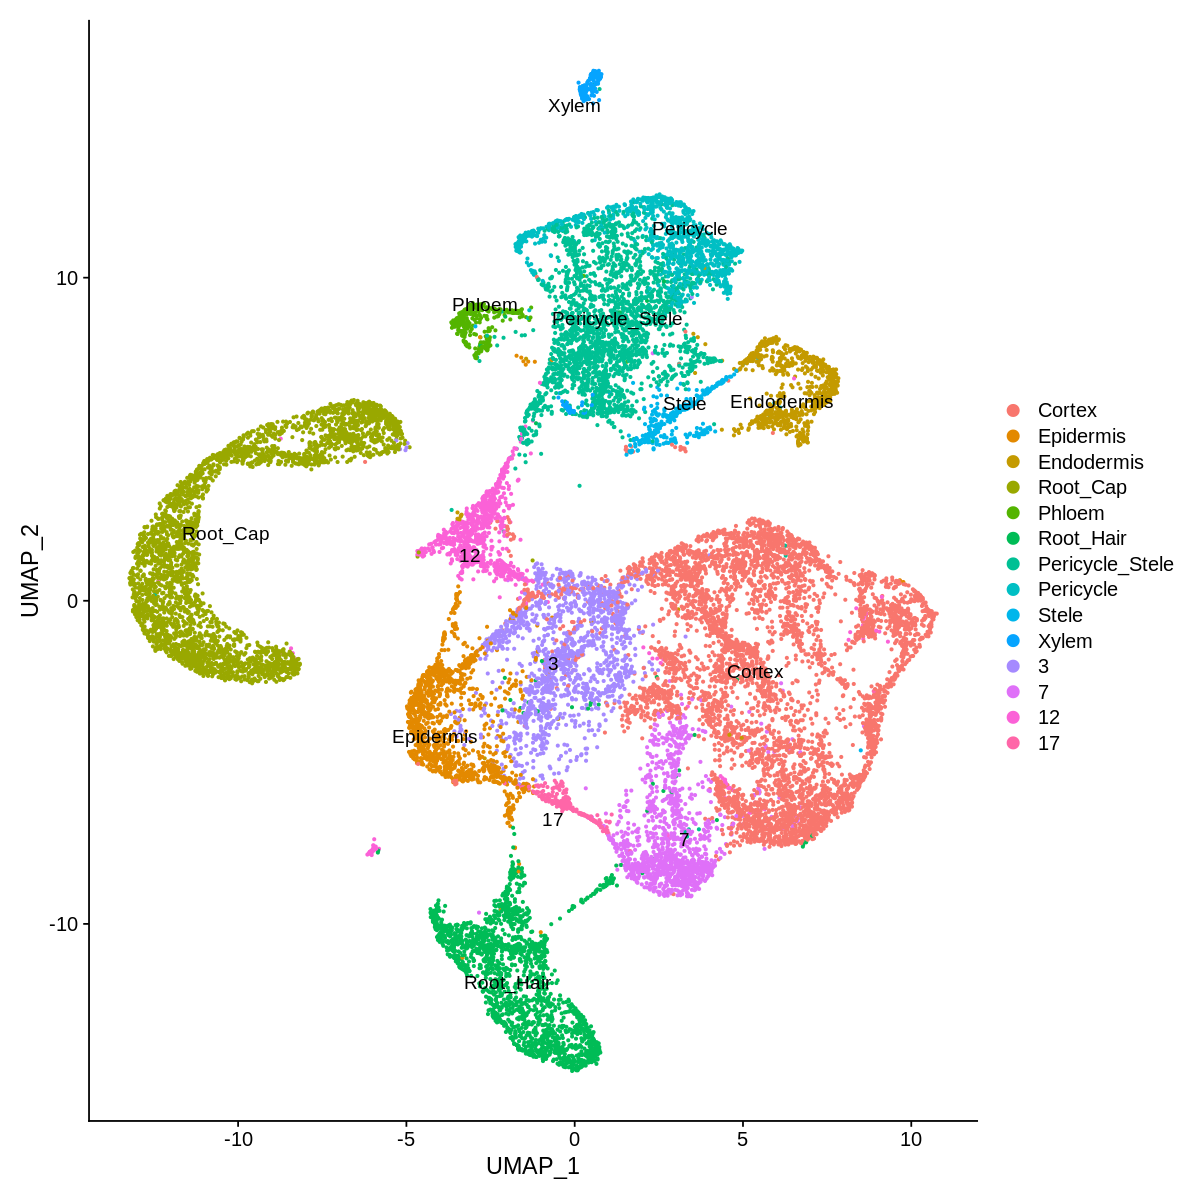

In [131]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 0.5)

### Bonus - Assigning a mixed cluster

In [133]:
seurat.clustered@meta.data$Cell_types <- Idents(seurat.clustered)

In [134]:
seurat.clustered@meta.data$Cell_types_old <- Idents(seurat.clustered)

In [135]:
peri = seurat.clustered@meta.data$Pericycle_scoring[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele']
stel = seurat.clustered@meta.data$Stele_scoring[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele']
peri_stele = peri>=stel
finalcl = c()
for(i in peri_stele)
    finalcl = c(finalcl, ifelse(i, "Pericycle", "Stele"))

seurat.clustered@meta.data$Cell_types[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele'] = finalcl
Idents(seurat.clustered) <- seurat.clustered@meta.data$Cell_types

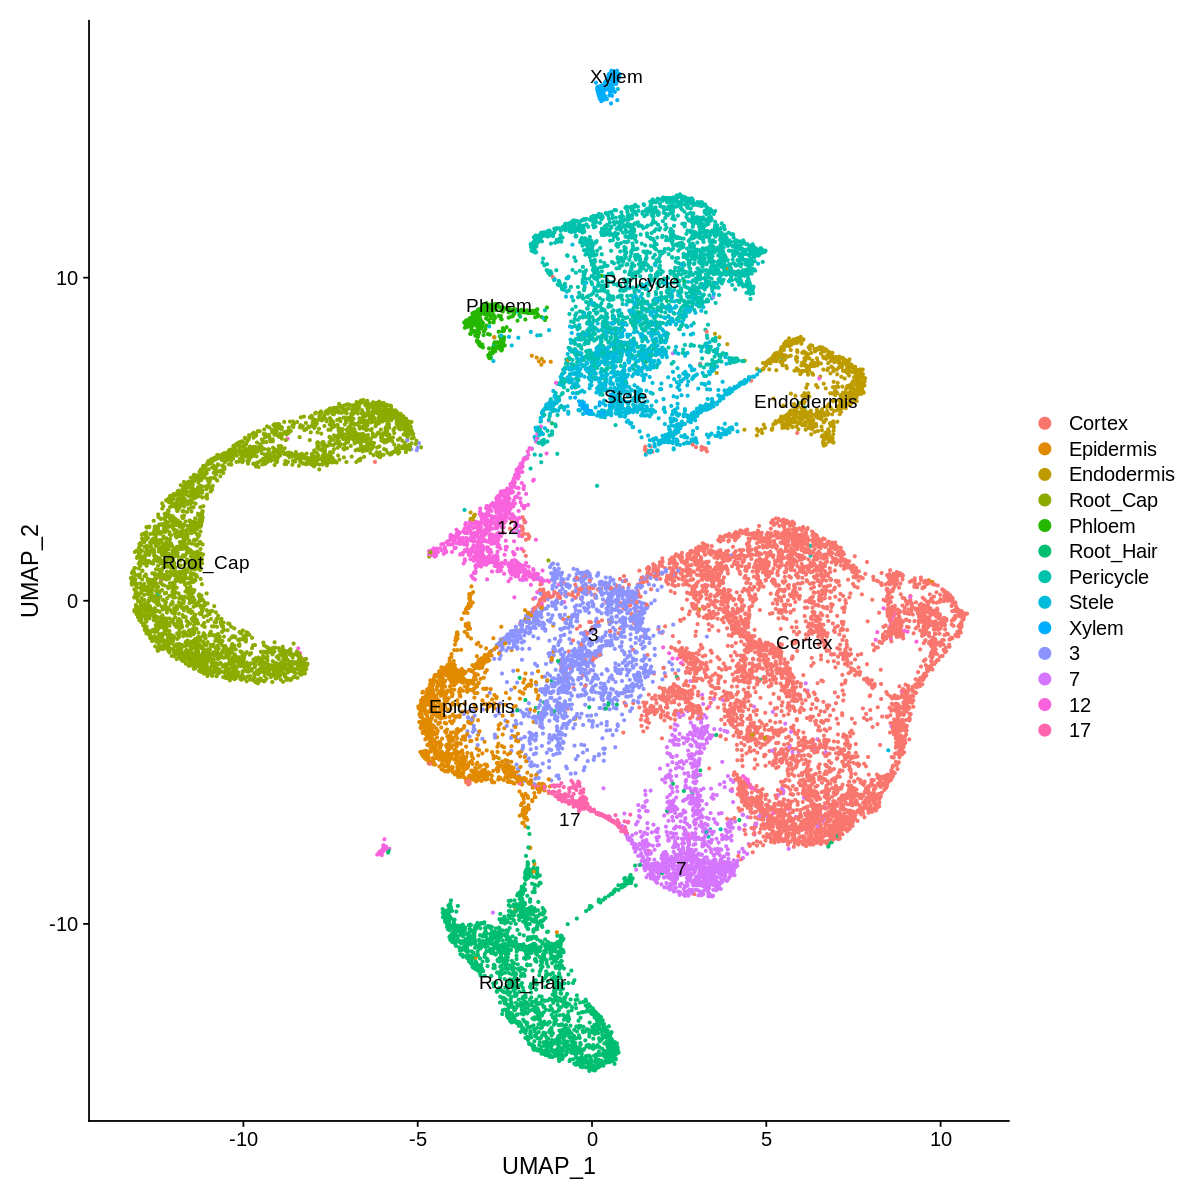

In [137]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 0.5)

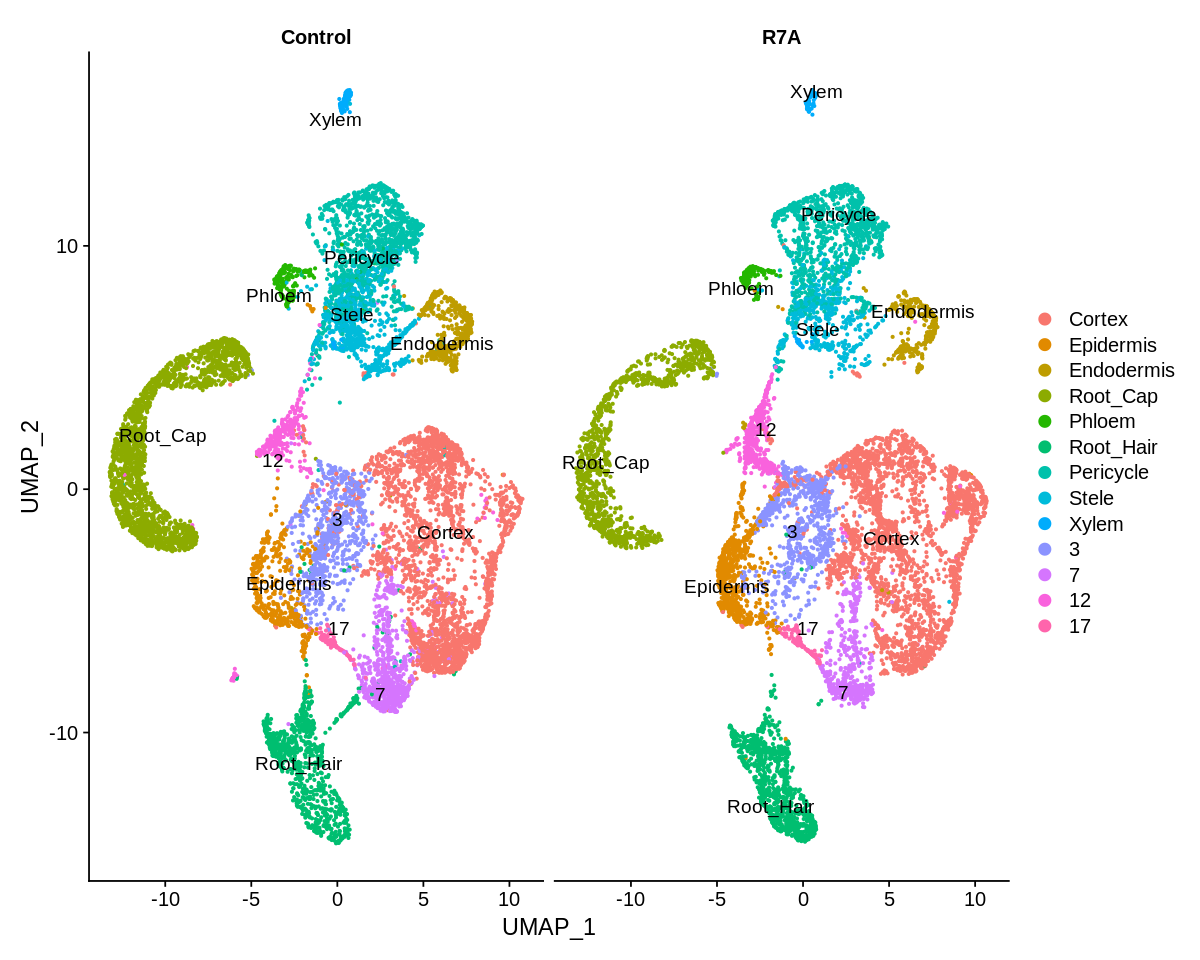

In [138]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.clustered, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5, split.by = 'Condition')

## Cluster assignment from an annotated dataset

In [141]:
seurat.reference <- readRDS("data_lavinia.RDS")

In [145]:
seurat.query <- seurat.clustered

In [149]:
DefaultAssay(seurat.query) <- "RNA"

In [161]:
lotusjaponicus.anchors <- FindTransferAnchors(reference = seurat.reference, 
                                        features = intersect( rownames(seurat.query), rownames( seurat.reference[['SCT']]@scale.data ) ),
                                        query = seurat.query, dims = 1:10, 
                                        reference.reduction = "pca")
#predictions <- TransferData(anchorset = lotusjaponicus.anchors, refdata = Idents(seurat.reference), dims = 1:10)
#seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 33531 anchors

Filtering anchors

	Retained 11781 anchors



In [162]:
saveRDS(lotusjaponicus.anchors, file = "anchors.RDS")

In [163]:
predictions <- TransferData(anchorset = lotusjaponicus.anchors, refdata = Idents(seurat.reference), dims = 1:10)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [164]:
seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions)

In [165]:
names( seurat.clustered@meta.data )

[1] "nCount_RNA"                        "nFeature_RNA"                     
 [3] "nCount_SCT"                        "nFeature_SCT"                     
 [5] "orig.ident"                        "Condition"                        
 [7] "percent.mt"                        "percent.chloroplast"              
 [9] "pANN_0.25_0.09_609"                "DF.classifications_0.25_0.09_609" 
[11] "pANN_0.25_0.09_329"                "DF.classifications_0.25_0.09_329" 
[13] "pANN_0.25_0.09_309"                "DF.classifications_0.25_0.09_309" 
[15] "pANN_0.25_0.09_110"                "DF.classifications_0.25_0.09_110" 
[17] "integrated_snn_res.0.5"            "seurat_clusters"                  
[19] "integrated_snn_res.0.25"           "Cell_types"                       
[21] "Cortex_scoring"                    "Epidermis_scoring"                
[23] "Endodermis_scoring"                "RootCap_scoring"                  
[25] "Meristem_scoring"                  "Phloem_scoring"                   
[27] "QuiescentCenter_scoring"           "RootHair_scoring"                 
[29] "Pericycle_scoring"                 "Stele_scoring"                    
[31] "Xylem_scoring"                     "Cell_types_old"                   
[33] "predicted.id"                      "prediction.score.Pericycle"       
[35] "prediction.score.Root.tip"         "prediction.score.Atrichoblasts"   
[37] "prediction.score.Trichoblasts"     "prediction.score.Meristem"        
[39] "prediction.score.Phloem"           "prediction.score.Cortex"          
[41] "prediction.score.Stele"            "prediction.score.Endodermis"      
[43] "prediction.score.Xylem"            "prediction.score.Quiescent.center"
[45] "prediction.score.max"

In [166]:
Idents(seurat.clustered) <- 'predicted.id'

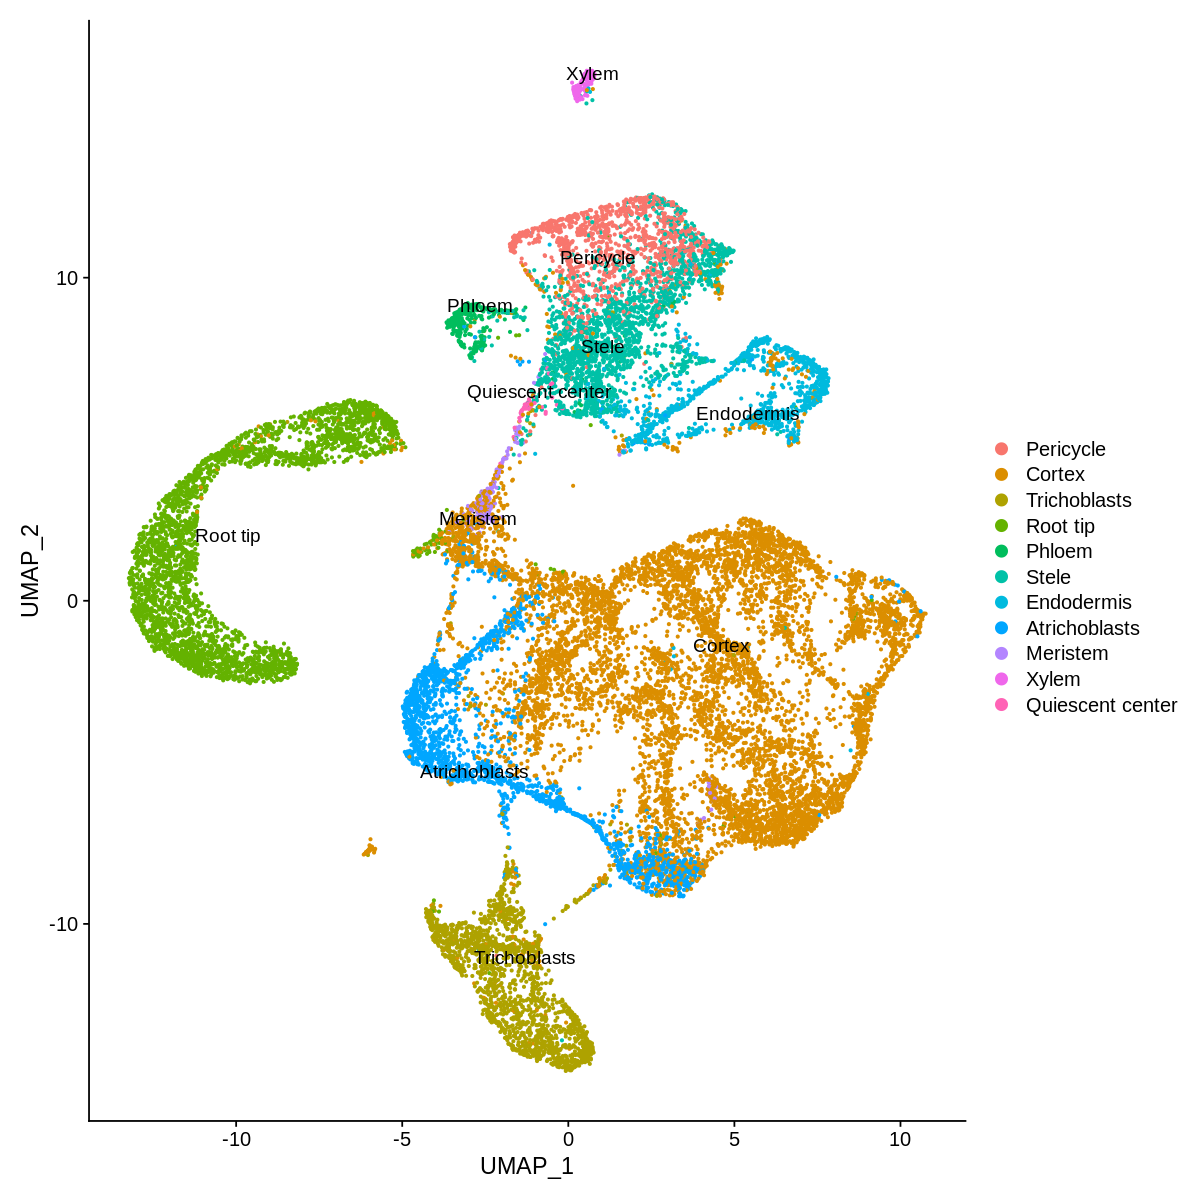

In [167]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 0.5)

# Assign cell types with gene ontologies and conserved markers

We try to use **conserved markers and a Gene Ontology database** (from [lotus.au.dk](lotus.au.dk)) to identify the cell types we could not find easily visually. Conserved markers are genes that are expressed in a specific cell type across different individuals, species, or experimental conditions.

We run a function that does that and then calculates the logfold change of the markers in each cluster (how many times each gene is more expressed in a cluster than in the others).

In [71]:
get_conserved <- function(cluster){
  FindConservedMarkers(seurat.integrated, 
                       ident.1 = cluster,
                       grouping.var = "Condition",
                       only.pos = TRUE,
                       verbose=TRUE) %>%
    rownames_to_column(var = "gene") %>%
    cbind(cluster_id = cluster, .)
}

In [72]:
clusters <- levels(seurat.integrated@active.ident)
conserved_markers <- map_dfr(c(clusters), get_conserved)

conserved_markers$Average_log2FC <- (conserved_markers$Control_avg_log2FC + conserved_markers$R7A_avg_log2FC) /2

Testing group R7A: (Cortex) vs (Epidermis, Root_Cap, Root_Hair, Quiescent_Center, Pericycle, 13, 9, Meristem, Endodermis, 6, 11, Xylem, Phloem)

Testing group Control: (Cortex) vs (Pericycle, 9, Root_Hair, Root_Cap, Meristem, Phloem, Quiescent_Center, 6, Epidermis, Endodermis, 13, 11, Xylem)

Testing group R7A: (Epidermis) vs (Root_Cap, Root_Hair, Quiescent_Center, Pericycle, 13, 9, Meristem, Endodermis, Cortex, 6, 11, Xylem, Phloem)

Testing group Control: (Epidermis) vs (Pericycle, 9, Root_Hair, Root_Cap, Meristem, Phloem, Quiescent_Center, Cortex, 6, Endodermis, 13, 11, Xylem)

Testing group R7A: (Endodermis) vs (Epidermis, Root_Cap, Root_Hair, Quiescent_Center, Pericycle, 13, 9, Meristem, Cortex, 6, 11, Xylem, Phloem)

Testing group Control: (Endodermis) vs (Pericycle, 9, Root_Hair, Root_Cap, Meristem, Phloem, Quiescent_Center, Cortex, 6, Epidermis, 13, 11, Xylem)

Testing group R7A: (Root_Cap) vs (Epidermis, Root_Hair, Quiescent_Center, Pericycle, 13, 9, Meristem, Endodermis, Cort

We can save conserved markers as a csv file. It can be opened in jupyterlab like a normal excel table.

In [73]:
write.csv(conserved_markers, "conserved_markers.csv")

or loaded using `read.csv`

In [74]:
conserved_markers <- read.csv("conserved_markers.csv")

In [75]:
head(conserved_markers)

X cluster_id gene               R7A_p_val R7A_avg_log2FC R7A_pct.1 R7A_pct.2
1 1 Cortex     LotjaGi1g1v0022100 0         2.3828737      0.788     0.112    
2 2 Cortex     LotjaGi1g1v0348000 0         1.4050453      0.507     0.044    
3 3 Cortex     LotjaGi1g1v0515200 0         1.8206883      0.738     0.238    
4 4 Cortex     LotjaGi1g1v0594900 0         2.6376294      0.596     0.138    
5 5 Cortex     LotjaGi1g1v0608900 0         0.7314322      0.368     0.064    
6 6 Cortex     LotjaGi3g1v0443150 0         0.6298841      0.333     0.038    
  R7A_p_val_adj Control_p_val Control_avg_log2FC Control_pct.1 Control_pct.2
1 0             0             3.237543           0.918         0.208        
2 0             0             2.077124           0.529         0.059        
3 0             0             2.044277           0.799         0.254        
4 0             0             3.021305           0.585         0.175        
5 0             0             1.574386           0.572         0.132        
6 0             0             1.460209           0.604         0.106        
  Control_p_val_adj max_pval minimump_p_val Average_log2FC
1 0                 0        0              2.810208      
2 0                 0        0              1.741084      
3 0                 0        0              1.932483      
4 0                 0        0              2.829467      
5 0                 0        0              1.152909      
6 0                 0        0              1.045046

We can use the top conserved markers (the ones with highest logfold change and percentage of cells expressing them in a cluster), to identify the unknown clusters making use of the Gene Ontology terms.

We open the gene ontology table

In [76]:
go_table <- read.table("./LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

This contains genes and ontology descriptions that can be useful for identifying functions of conserved markers. 

In [77]:
head( go_table )

V1                  
1 LotjaGi0g1v0000400.1
2 LotjaGi0g1v0000400.1
3 LotjaGi0g1v0000400.1
4 LotjaGi0g1v0000400.1
5 LotjaGi0g1v0000400.2
6 LotjaGi0g1v0000400.2
  V2                                                                                                                                                                                                                                                                                   
1 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
2 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
3 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
4 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
5 protein kinase family protein; TAIR: AT3G57530.1 calcium-dependent protein kinase 32; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|V7CVU7|V7CVU7_PHAVU Uncharacterized protein; Found in the gene: LotjaGi0g1v0000400                    
6 protein kinase family protein; TAIR: AT3G57530.1 calcium-dependent protein kinase 32; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|V7CVU7|V7CVU7_PHAVU Uncharacterized protein; Found in the gene: LotjaGi0g1v0000400

The code below creates a table for all clusters in the data. For each cluster, it shows all GO terms from highly conserved markers.

In [78]:
clusters_go_terms <- data.frame()
for(i in unique(seurat.integrated@active.ident) ){
    subset <- conserved_markers %>% filter(cluster_id=="Cortex") %>% arrange(-Average_log2FC)
    temp_table <- data.frame()
    for(j in subset$gene[1:30]){
        temp_table <- rbind(temp_table, go_table[ grepl(j, go_table[,2]), ]  )
        
        }
    temp_table$'Cluster' <- rep(i, nrow(temp_table))
    clusters_go_terms <- rbind(clusters_go_terms, temp_table)   
    }

You can choose any cluster and see its GO terms

In [79]:
unique( clusters_go_terms[ clusters_go_terms$Cluster=='Phloem',] )

V1                  
65205  LotjaGi1g1v0348000.1
369185 LotjaGi3g1v0541800.1
121255 LotjaGi1g1v0608900.1
593505 LotjaGi6g1v0254700.1
593555 LotjaGi6g1v0254700.2
1985   LotjaGi1g1v0006200.1
2005   LotjaGi1g1v0006200.2
255755 LotjaGi3g1v0002700.1
330175 LotjaGi3g1v0360700.1
330205 LotjaGi3g1v0360700.2
330235 LotjaGi3g1v0360700.3
387505 LotjaGi4g1v0062900.1
291525 LotjaGi3g1v0149500.1
10835  LotjaGi1g1v0048200.1
10845  LotjaGi1g1v0048200.2
155975 LotjaGi1g1v0769400.1
155985 LotjaGi1g1v0769400.2
285005 LotjaGi3g1v0120800.1
376595 LotjaGi4g1v0014800.1
514285 LotjaGi5g1v0215000.1
514305 LotjaGi5g1v0215000.2
514325 LotjaGi5g1v0215000.3
       V2                                                                                                                                                                                                                                                                                                                                                
65205  Aspartic proteinase nepenthesin-1; TAIR: AT1G09750.1 Eukaryotic aspartyl protease family protein; Swiss-Prot: sp|O04496|AED3_ARATH Aspartyl protease AED3; TrEMBL-Plants: tr|Q2PEZ2|Q2PEZ2_TRIPR Putative uncharacterized protein; Found in the gene: LotjaGi1g1v0348000                                                                          
369185 S-norcoclaurine synthase 1; TAIR: AT2G26040.1 PYR1-like 2; Swiss-Prot: sp|Q4QTJ1|NCS2_PAPSO S-norcoclaurine synthase 2; TrEMBL-Plants: tr|I3SPM5|I3SPM5_LOTJA Uncharacterized protein; Found in the gene: LotjaGi3g1v0541800                                                                                                                      
121255 2-oxoglutarate (2OG) and Fe(II)-dependent oxygenase superfamily protein; TAIR: AT3G21420.1 2-oxoglutarate (2OG) and Fe(II)-dependent oxygenase superfamily protein; Swiss-Prot: sp|Q39224|SRG1_ARATH Protein SRG1; TrEMBL-Plants: tr|A0A072U060|A0A072U060_MEDTR 2OG-Fe(II) oxygenase family oxidoreductase; Found in the gene: LotjaGi1g1v0608900
593505 Class-10 pathogenesis-related protein 1; TAIR: AT1G24020.1 MLP-like protein 423; Swiss-Prot: sp|P93333|PR101_MEDTR Class-10 pathogenesis-related protein 1; TrEMBL-Plants: tr|I3SRT2|I3SRT2_LOTJA Uncharacterized protein; Found in the gene: LotjaGi6g1v0254700                                                                                  
593555 Major allergen d 1; TAIR: AT1G24020.1 MLP-like protein 423; Swiss-Prot: sp|P93333|PR101_MEDTR Class-10 pathogenesis-related protein 1; TrEMBL-Plants: tr|I3SSP7|I3SSP7_LOTJA Uncharacterized protein; Found in the gene: LotjaGi6g1v0254700                                                                                                       
1985   Chalcone reductase; TAIR: AT1G59960.1 NAD(P)-linked oxidoreductase superfamily protein; Swiss-Prot: sp|P26690|6DCS_SOYBN NAD(P)H-dependent 6'-deoxychalcone synthase; TrEMBL-Plants: tr|I3T5M5|I3T5M5_LOTJA Uncharacterized protein; Found in the gene: LotjaGi1g1v0006200                                                                        
2005   Chalcone reductase; TAIR: AT1G59950.1 NAD(P)-linked oxidoreductase superfamily protein; Swiss-Prot: sp|P26690|6DCS_SOYBN NAD(P)H-dependent 6'-deoxychalcone synthase; TrEMBL-Plants: tr|I3T585|I3T585_LOTJA Uncharacterized protein; Found in the gene: LotjaGi1g1v0006200                                                                        
255755 Cytochrome P450; TAIR: AT5G25900.1 GA requiring 3; Swiss-Prot: sp|Q93ZB2|KO1_ARATH Ent-kaurene oxidase, chloroplastic; TrEMBL-Plants: tr|A0A151S6N4|A0A151S6N4_CAJCA Ent-kaurene oxidase; Found in the gene: LotjaGi3g1v0002700                                                                                                                   
330175 Pleiotropic drug resistance ABC transporter; TAIR: AT1G15520.1 pleiotropic drug resistance 12; Swiss-Prot: sp|Q76CU2|PDR1_TOBAC Pleiotropic drug resistance protein 1; TrEMBL-Plants: tr|A0A0A1H9X9|A0A0A1H9X9_LOTJA ATP binding cassette transpor

In [80]:
unique( clusters_go_terms[ clusters_go_terms$Cluster=='9',] )

V1                  
65201  LotjaGi1g1v0348000.1
369181 LotjaGi3g1v0541800.1
121251 LotjaGi1g1v0608900.1
593501 LotjaGi6g1v0254700.1
593551 LotjaGi6g1v0254700.2
1981   LotjaGi1g1v0006200.1
2001   LotjaGi1g1v0006200.2
255751 LotjaGi3g1v0002700.1
330171 LotjaGi3g1v0360700.1
330201 LotjaGi3g1v0360700.2
330231 LotjaGi3g1v0360700.3
387501 LotjaGi4g1v0062900.1
291521 LotjaGi3g1v0149500.1
10831  LotjaGi1g1v0048200.1
10841  LotjaGi1g1v0048200.2
155971 LotjaGi1g1v0769400.1
155981 LotjaGi1g1v0769400.2
285001 LotjaGi3g1v0120800.1
376591 LotjaGi4g1v0014800.1
514281 LotjaGi5g1v0215000.1
514301 LotjaGi5g1v0215000.2
514321 LotjaGi5g1v0215000.3
       V2                                                                                                                                                                                                                                                                                                                                                
65201  Aspartic proteinase nepenthesin-1; TAIR: AT1G09750.1 Eukaryotic aspartyl protease family protein; Swiss-Prot: sp|O04496|AED3_ARATH Aspartyl protease AED3; TrEMBL-Plants: tr|Q2PEZ2|Q2PEZ2_TRIPR Putative uncharacterized protein; Found in the gene: LotjaGi1g1v0348000                                                                          
369181 S-norcoclaurine synthase 1; TAIR: AT2G26040.1 PYR1-like 2; Swiss-Prot: sp|Q4QTJ1|NCS2_PAPSO S-norcoclaurine synthase 2; TrEMBL-Plants: tr|I3SPM5|I3SPM5_LOTJA Uncharacterized protein; Found in the gene: LotjaGi3g1v0541800                                                                                                                      
121251 2-oxoglutarate (2OG) and Fe(II)-dependent oxygenase superfamily protein; TAIR: AT3G21420.1 2-oxoglutarate (2OG) and Fe(II)-dependent oxygenase superfamily protein; Swiss-Prot: sp|Q39224|SRG1_ARATH Protein SRG1; TrEMBL-Plants: tr|A0A072U060|A0A072U060_MEDTR 2OG-Fe(II) oxygenase family oxidoreductase; Found in the gene: LotjaGi1g1v0608900
593501 Class-10 pathogenesis-related protein 1; TAIR: AT1G24020.1 MLP-like protein 423; Swiss-Prot: sp|P93333|PR101_MEDTR Class-10 pathogenesis-related protein 1; TrEMBL-Plants: tr|I3SRT2|I3SRT2_LOTJA Uncharacterized protein; Found in the gene: LotjaGi6g1v0254700                                                                                  
593551 Major allergen d 1; TAIR: AT1G24020.1 MLP-like protein 423; Swiss-Prot: sp|P93333|PR101_MEDTR Class-10 pathogenesis-related protein 1; TrEMBL-Plants: tr|I3SSP7|I3SSP7_LOTJA Uncharacterized protein; Found in the gene: LotjaGi6g1v0254700                                                                                                       
1981   Chalcone reductase; TAIR: AT1G59960.1 NAD(P)-linked oxidoreductase superfamily protein; Swiss-Prot: sp|P26690|6DCS_SOYBN NAD(P)H-dependent 6'-deoxychalcone synthase; TrEMBL-Plants: tr|I3T5M5|I3T5M5_LOTJA Uncharacterized protein; Found in the gene: LotjaGi1g1v0006200                                                                        
2001   Chalcone reductase; TAIR: AT1G59950.1 NAD(P)-linked oxidoreductase superfamily protein; Swiss-Prot: sp|P26690|6DCS_SOYBN NAD(P)H-dependent 6'-deoxychalcone synthase; TrEMBL-Plants: tr|I3T585|I3T585_LOTJA Uncharacterized protein; Found in the gene: LotjaGi1g1v0006200                                                                        
255751 Cytochrome P450; TAIR: AT5G25900.1 GA requiring 3; Swiss-Prot: sp|Q93ZB2|KO1_ARATH Ent-kaurene oxidase, chloroplastic; TrEMBL-Plants: tr|A0A151S6N4|A0A151S6N4_CAJCA Ent-kaurene oxidase; Found in the gene: LotjaGi3g1v0002700                                                                                                                   
330171 Pleiotropic drug resistance ABC transporter; TAIR: AT1G15520.1 pleiotropic drug resistance 12; Swiss-Prot: sp|Q76CU2|PDR1_TOBAC Pleiotropic drug resistance protein 1; TrEMBL-Plants: tr|A0A0A1H9X9|A0A0A1H9X9_LOTJA ATP binding cassette transpor

If you are in possess of the biological knowledge necessary to identify the unnamed clusters from the table we just created then you can add those names for example with 

```
seurat.integrated <- RenameIdents(object = seurat.integrated,
                               "13"="name13",
                               "11"="name11",
                               "9"="name9",  
                               "6"="name6")
```

You can save the table with

In [81]:
write.csv(clusters_go_terms, "clusters_go_terms.csv")

# Differential Gene Expression 

We now try to identify cells expressing a certain gene (HAR1) and compare two conditions of interest, to find which are the differences between those cells.

The gene ID we need for HAR1 is `LotjaGi3g1v0512000`.

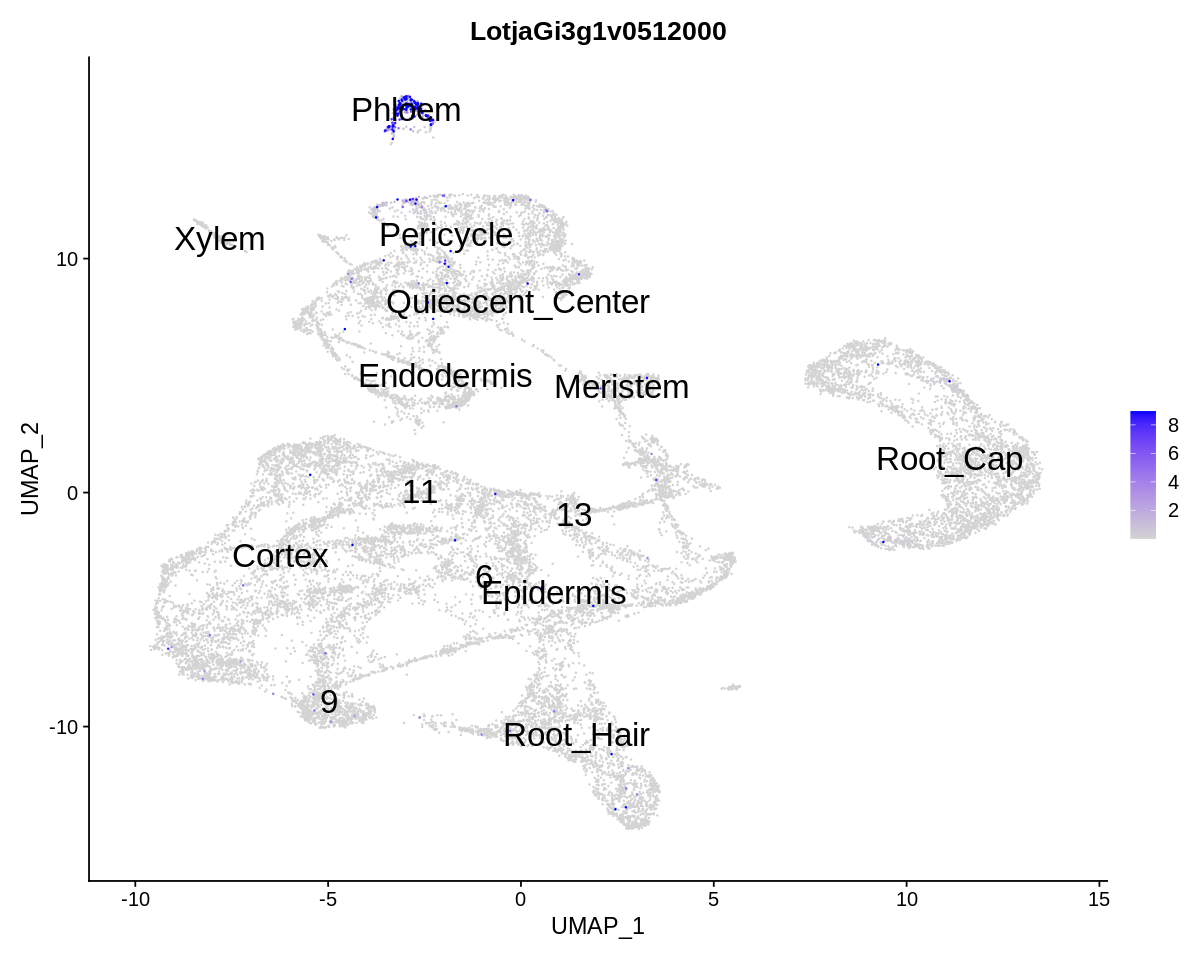

In [82]:
FeaturePlot(seurat.integrated, 
            reduction = "umap", 
            features = c("LotjaGi3g1v0512000"), 
            order = TRUE,
            min.cutoff = 'q10',
            max.cutoff = 'q90', 
            label = TRUE, 
            label.size = 7) + theme(legend.position = "right")

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



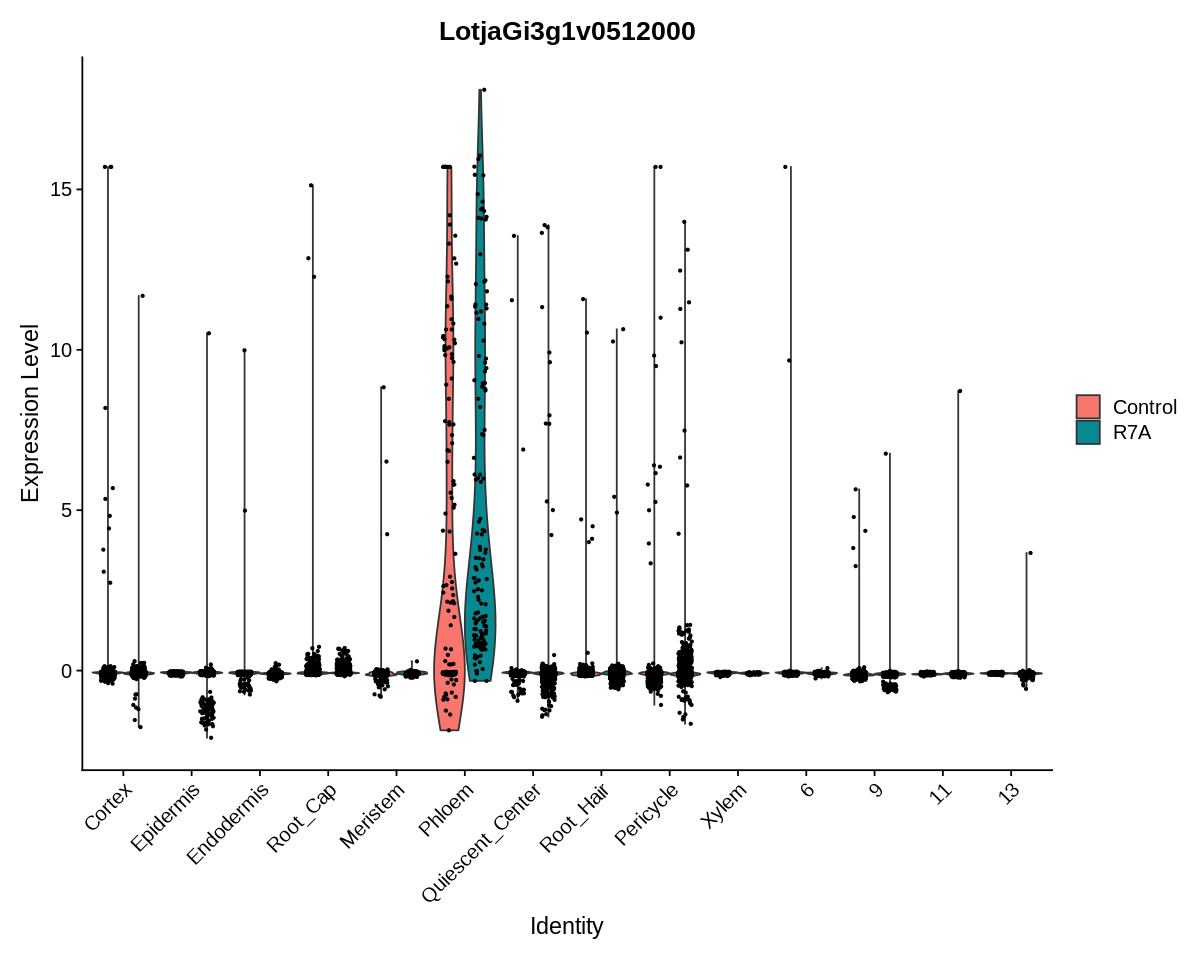

In [83]:
VlnPlot(seurat.integrated,  group.by = 'Cell_types', split.by = 'Condition',
            features = c("LotjaGi3g1v0512000"))

As expected from buiological knowledge, this is mostly expressed in the Phloem cluster. Let's make a subset of the data with the cells expressing `HAR1`.

In [84]:
HAR1.integrated <- seurat.integrated[, as.numeric(GetAssayData(seurat.integrated["LotjaGi3g1v0512000",]))>0 ]

Now we calculate differentially expressed genes so that we can compare the two conditions, and see which genes are differentially expressed across them. The reference for the comparison is the `R7A` condition against `Control`.

We combine the `FindMarkers` command with two filters to remove non-singnificant genes (keeping p-value below 0.05) which are present in less that 5% of the cells.

In [85]:
Idents(HAR1.integrated) <- HAR1.integrated@meta.data$Condition

In [86]:
DEG_table <- FindMarkers(HAR1.integrated, 
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             verbose = TRUE, 
                             DE_result.use = "MAST") %>%
                        filter(p_val_adj <= 0.05) %>%
                        filter(pct.1 > .05)

The table looks like this. Columns represent: 
* p-value
* average logfoldchange between R7A and Control
* percentage of cells in R7A expressing the gene
* percentage of cells in Control expressing the gene
* adjusted p-value

In [87]:
DEG_table

p_val        avg_log2FC  pct.1 pct.2 p_val_adj   
LotjaGi6g1v0210700    4.355171e-32  -4.1442672 0.282 0.095 1.306551e-28
LotjaGi3g1v0038500    1.801668e-30  -3.8961501 0.190 0.113 5.405005e-27
LotjaGi2g1v0380000    1.304405e-28  -0.6154037 0.184 0.055 3.913216e-25
LotjaGi5g1v0027500    9.167377e-28   1.3247534 0.173 0.079 2.750213e-24
LotjaGi5g1v0301200-LC 7.152508e-27  -2.6217188 0.266 0.152 2.145752e-23
LotjaGi6g1v0038700    1.526760e-26   1.6168325 0.170 0.079 4.580281e-23
LotjaGi4g1v0185900    3.352950e-26  -3.6051234 0.270 0.159 1.005885e-22
LotjaGi6g1v0054200    1.209777e-25   3.0419943 0.108 0.079 3.629330e-22
LotjaGi3g1v0419600    1.830771e-25   6.7333698 0.201 0.110 5.492313e-22
LotjaGi6g1v0331800    3.387374e-25   4.7020108 0.344 0.198 1.016212e-21
LotjaGi6g1v0194600    1.909132e-24  -4.5048648 0.168 0.079 5.727397e-21
LotjaGi4g1v0222650    2.751755e-24   7.4153108 0.240 0.085 8.255265e-21
LotjaGi3g1v0123200    2.799139e-24  -0.7939240 0.283 0.220 8.397417e-21
LotjaGi1g1v0409900    5.014860e-24   7.3199029 0.117 0.131 1.504458e-20
LotjaGi6g1v0361100    7.420761e-24  -5.1576205 0.179 0.113 2.226228e-20
LotjaGi3g1v0175300    1.577540e-23   5.3671924 0.339 0.125 4.732620e-20
LotjaGi4g1v0244600    4.594770e-23  -0.7654334 0.313 0.091 1.378431e-19
LotjaGi6g1v0356800    7.696550e-23  -6.7595021 0.106 0.021 2.308965e-19
LotjaGi3g1v0040500    8.138033e-23  -0.6143595 0.125 0.125 2.441410e-19
LotjaGi1g1v0309600    1.454484e-22 -12.6594184 0.126 0.125 4.363453e-19
LotjaGi3g1v0185300    1.624920e-22  -6.9930682 0.204 0.067 4.874761e-19
LotjaGi1g1v0628500    2.737455e-22   1.7225629 0.203 0.095 8.212366e-19
LotjaGi1g1v0647000    2.793864e-22   2.4725754 0.230 0.052 8.381593e-19
LotjaGi3g1v0300800    2.945969e-22  12.5847894 0.232 0.043 8.837908e-19
LotjaGi1g1v0783400    3.138067e-22  -2.1993219 0.243 0.137 9.414201e-19
LotjaGi2g1v0214300    3.288553e-22  -4.9111330 0.282 0.113 9.865660e-19
LotjaGi3g1v0121000    3.574733e-22   3.7359083 0.114 0.085 1.072420e-18
LotjaGi2g1v0021500    4.451967e-22   7.3470356 0.234 0.122 1.335590e-18
LotjaGi6g1v0099800    4.721795e-22   4.5136116 0.143 0.030 1.416538e-18
LotjaGi4g1v0171900    5.375877e-22   1.2497587 0.217 0.125 1.612763e-18
⋮                     ⋮            ⋮           ⋮     ⋮     ⋮           
LotjaGi5g1v0322100    1.012999e-05   5.7558423 0.213 0.076 0.03038997  
LotjaGi1g1v0783700-LC 1.053674e-05   4.7493694 0.226 0.088 0.03161023  
LotjaGi1g1v0364300    1.063829e-05  -1.8685767 0.152 0.088 0.03191487  
LotjaGi4g1v0334300    1.101166e-05   4.5364590 0.134 0.058 0.03303498  
LotjaGi1g1v0769100    1.143025e-05  -1.6860791 0.181 0.049 0.03429075  
LotjaGi3g1v0146300    1.151797e-05   2.4260402 0.240 0.152 0.03455391  
LotjaGi6g1v0236600    1.152898e-05  -4.7599594 0.110 0.137 0.03458694  
LotjaGi6g1v0342200    1.179626e-05   3.3262410 0.201 0.159 0.03538879  
LotjaGi3g1v0432500    1.195490e-05   0.9244777 0.135 0.098 0.03586470  
LotjaGi6g1v0351600    1.195490e-05  -0.2778889 0.255 0.201 0.03586470  
LotjaGi2g1v0429600    1.219667e-05   4.4105497 0.152 0.143 0.03659002  
LotjaGi6g1v0151500    1.264607e-05   1.0997405 0.087 0.131 0.03793821  
LotjaGi2g1v0431500    1.268223e-05  -2.0767808 0.149 0.125 0.03804668  
LotjaGi1g1v0076700    1.296263e-05   3.5270895 0.127 0.116 0.03888788  
LotjaGi4g1v0359500    1.304914e-05   4.0224043 0.122 0.073 0.03914741  
LotjaGi2g1v0166000    1.314867e-05  -3.9158757 0.175 0.064 0.03944602  
LotjaGi4g1v0045100    1.347721e-05  -0.7966484 0.100 0.061 0.04043162  
LotjaGi6g1v0212400    1.350280e-05   4.4119247 0.113 0.174 0.04050840  
LotjaGi3g1v0233700    1.354128e-05  -3.2295923 0.275 0.134 0.04062383  
LotjaGi3g1v0046800    1.381356e-05   3.5068817 0.277 0.253 0.04144068  
LotjaGi5g1v0316500    1.406440e-05   1.0983693 0.147 0.110 0.04219321  
LotjaGi4g1v0165800    1.485729e-05   1.1237763 0.248 0.076 0.04457187  
LotjaGi6g1v0266650    1.494170e-05   9.1339640 0.182 0.226 0.04482511  
LotjaGi4g1v0348500    1.498408e-05  -3.9771793 0.360 0.299 0.0

We save the table:

In [88]:
write.csv(DEG_table, "DEG_HAR1_table.csv")

# Coexpression Networks

We Identify now the networks of genes involved in each condition using the HAR1-subset data. A network of gene is a group of genes whose that is highly correlated. To find those networks we use the package `fcoex`. It provides a pipeline for the identification of co-expression gene networks, which can be used to identify genes that are functionally related and potentially involved in similar biological processes.

The fcoex package uses a so-called weighted gene co-expression network analysis (WGCNA) approach to construct co-expression networks. This involves first calculating a pairwise correlation matrix between all genes in the dataset, followed by a "soft-thresholding" step to transform the correlation matrix into a weighted adjacency matrix. The resulting adjacency matrix is then used to identify clusters of highly interconnected genes, which are referred to as "modules". Each module represents a potential biological pathway or process that the genes within it may be involved in.

The only input needed for the software is the expression matrix and a clustering of the data with identified cell types.

-----------

We subset the data to the `Control` and `R7A` conditions and create objects for the `fcoex` package

In [89]:
seurat.control <- seurat.integrated[ , seurat.integrated@meta.data$Condition=='Control' ]
seurat.r7a <- seurat.integrated[ , seurat.integrated@meta.data$Condition=='R7A' ]

exprs <- data.frame(GetAssayData(seurat.control))
target <- Idents(seurat.control)
fc.control <- new_fcoex(data.frame(exprs), target)

exprs <- data.frame(GetAssayData(seurat.r7a))
target <- Idents(seurat.r7a)
fc.r7a <- new_fcoex(data.frame(exprs), target)

Created new fcoex object.

Created new fcoex object.



The following two commands identify the modules of correlated genes. `find_cbf_modules` finds out automatically the correlation thresholds for which genes can be considered actually correlated.

Note: there might be warning messages of the type `“cannot xtfrm data frames”`. It is only a formatting issue, but does not create any problem.

In [ ]:
fc.control <- discretize(fc.control)
fc.control <- find_cbf_modules(fc.control, verbose = FALSE, is_parallel = FALSE)

Getting SU scores for each gene



In [91]:
fc.r7a <- discretize(fc.r7a)
fc.r7a <- find_cbf_modules(fc.r7a, verbose = FALSE, is_parallel = FALSE)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Trimming and getting modules from adjacency matrix

11 modules were found.



We extract the network of genes from the modules identified above.

In [ ]:
fc.control <- get_nets(fc.control)

In [ ]:
fc.r7a <- get_nets(fc.r7a)

## Visualization of networks on UMAP

Each module (network of correlated genes) is identified by the gene that best describe all the others. Let's see how many modules there are and which genes describe them

In [ ]:
cat("There are ")

cat( length( mod_names(fc.control) ) )

cat(" modules with representative genes \n")

cat(  mod_names(fc.control), sep="\n"  )

cat("for the CONTROL dataset")

In [ ]:
cat("There are ")

cat( length( mod_names(fc.r7a) ) )

cat(" modules with representative genes \n")

cat(  mod_names(fc.r7a), sep="\n"  )

cat("for the R7A dataset")

Why not printing those representatives on the UMAP plot of the data?

In [ ]:
options(repr.plot.width=12, repr.plot.height=40)

FeaturePlot(seurat.integrated, split.by = 'Condition',
            reduction = "umap", 
            features = mod_names(fc.r7a), 
            order = TRUE,
            min.cutoff = 'q10',
            max.cutoff = 'q90', 
            label = TRUE, 
            ncol=2,
            label.size = 7) + theme(legend.position = "right")

In [ ]:
options(repr.plot.width=12, repr.plot.height=40)

FeaturePlot(seurat.integrated, split.by = 'Condition',
            reduction = "umap", 
            features = mod_names(fc.control), 
            order = TRUE,
            min.cutoff = 'q10',
            max.cutoff = 'q90', 
            label = TRUE, 
            ncol=2,
            label.size = 7) + theme(legend.position = "right")

## Finding some common genes between condition

We can find one network - part of the `control` networks - with a representative clearly expressed in the Phloem. Let's see the genes contained in this network.

In [1]:
fc.control@module_list[['LotjaGi2g1v0386600']]

ERROR: Error in eval(expr, envir, enclos): object 'fc.control' not found


Now, let's see if in the `R7A` condition, we have some of those genes in another network:

In [ ]:
for(i in mod_names(fc.r7a)){
    inters <- intersect( fc.r7a@module_list[[i]], fc.control@module_list[['LotjaGi2g1v0386600']] )
    if(!length(inters)==0)
        cat("\nnetwork representative",i,"contains",inters,"\n" )

    }

We have one network of `R7A` with a gene in common. Let's look at the content:

In [ ]:
fc.r7a@module_list[['LotjaGi3g1v0222100']]

We have found two networks in the `control` and `R7A` conditions with one gene in common. Let's plot the two networks. No plot comes out of the `control` condition because the network is too small.

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
network_control <- show_net(fc.control)
network_control[['LotjaGi2g1v0386600']]

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
network_r7a <- show_net(fc.r7a)
network_r7a[['LotjaGi3g1v0222100']]

## Search GO terms from networks

One last thing you can do is to search in the GO terms table the genes found in the two networks to see their ontology terms.

In [ ]:
gotable <- read.table("./LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

We do that for the R7A condition

In [ ]:
gotable_r7a <- data.frame()
for(j in fc.r7a@module_list[['LotjaGi3g1v0222100']])
    gotable_r7a <- rbind(gotable_r7a, gotable[ grepl(j, gotable[,2]), ])        
gotable_r7a$'Representative' <- rep('LotjaGi3g1v0222100', nrow(gotable_r7a))

In [ ]:
gotable_r7a

and for the control condition:

In [ ]:
gotable_control <- data.frame()
for(j in fc.control@module_list[['LotjaGi2g1v0386600']])
    gotable_control <- rbind(gotable_control, gotable[ grepl(j, gotable[,2]), ])        
gotable_control$'Representative' <- rep('LotjaGi2g1v0386600', nrow(gotable_control))

In [ ]:
gotable_control

The tables can again be saved in csv format.

In [ ]:
write.csv(gotable_r7a, "network_goterms_r7a.csv")

In [ ]:
write.csv(gotable_control, "network_goterms_control.csv")